# Song lyrics analysis with text mining and songs recommendation
Author: Daniele Morotti

This notebook is split in two parts, at the beginning we analyze the song lyrics and the genres using some text mining techniques in order to explore the data.

In the last section of the notebook we will build a simple songs recommendation system that returns the most similar songs related to a given one. We used an evaluation dataset in order to evaluate numerically the suggestions of the system and to compute the mAP and the recall on these songs.

First of all we need to download and import some necessary libraries.

In [3]:
# Install and import the needed libraries
install.packages("lsa", quiet=T)
install.packages("tm", quiet=T)
install.packages("googledrive", quiet=T)

library("tm")
library("lsa")
library("googledrive")

also installing the dependency ‘SnowballC’


also installing the dependencies ‘NLP’, ‘Rcpp’, ‘slam’, ‘BH’


Loading required package: NLP

Loading required package: SnowballC



## Download the files and load the data

The used data are taken from the [Million Song Dataset](http://millionsongdataset.com/). In order to get more information about the songs, the musiXmatch and the Last.fm datasets are used as well. I implemented a script for the preprocessing and to merge toghether all the data, you can check the script at the [following link](https://drive.google.com/file/d/1UkFl8Cifzh3WSqreLxeKzBvFf1ppvYXe/view?usp=share_link).

We can download the ready-to-use dataset from Drive and we load it to a dataframe in order to use the songs for our analysis. 

In [4]:
# Download the file from Drive
url_dataset <- "https://drive.google.com/file/d/1-B9eJTAa7xBWJStv1r-169pPgtH3CVMb/view?usp=share_link"
url_evaluation <- "https://drive.google.com/file/d/1-6eIPU2Q2UF5oyynNH8ORWYR2jxyhkmE/view?usp=share_link"
drive_deauth()
dl_data <- drive_download(as_id(url_dataset), overwrite=TRUE)
dl_eval <- drive_download(as_id(url_evaluation), overwrite=TRUE)

File downloaded:

• songs_data.csv <id: 1-B9eJTAa7xBWJStv1r-169pPgtH3CVMb>

Saved locally as:

• songs_data.csv

File downloaded:

• evaluation_songs.csv <id: 1-6eIPU2Q2UF5oyynNH8ORWYR2jxyhkmE>

Saved locally as:

• evaluation_songs.csv



In [5]:
cat("Loading the dataset csv into a dataframe...")
songs_df <- read.csv(dl_data$local_path)
cat("\nThe dataframe is ready!")

Loading the dataset csv into a dataframe...
The dataframe is ready!

As you can see in the following cell, the dataset has 5 columns, the track id, the title, the artist name, the stemmed lyrics (in BOW version for copyright reasons) and the tag (genre) for each song.

In [ ]:
head(songs_df, n=2)

,track_id,title,artist_name,lyrics,tag
,<chr>,<chr>,<chr>,<chr>,<chr>
1,TRAAABD128F429CF47,Soul Deep,The Box Tops,i i i i i i i i i i you you you you you you you you you you you you you you you you you to to to to to to to to and and a a me it it it not not in in in my my my my is is is your your your your your your your that that that that that do do do do do are are are are are are for for for for no have have have have have have so so know know know know know but but but what what what when when time time time can there there there there there la la la la la la la get get got got got never never feel feel want want would would day day day day away away yeah yeah yeah yeah heart heart heart heart heart could could need need need our our look look where where thing thing think live onli onli tri keep keep keep dream dream wanna wanna wanna find find find hear believ everyth everyth someth someth someth someth insid insid chang chang soul soul soul soul soul soul soul new start start pleas pleas true while while deep deep deep deep beat after after fade fade wast wast wast trust alreadi alreadi style style asleep wors wors goal goal,60s
2,TRAAAED128E0783FAB,It's About Time,Jamie Cullum,i i i i i i i i i i i i i i i i i i i i i i i i i i i i the the the the the the the the the the the the the the the you you to to to to to to to to to to to to and and and and and and and and and and and and and and and and and and and and and and a a me me it it it it not not in my my my my my my my my my my my my my my my my my my my my is is is of that that that that that that that do do on are are am am am am am am am am will will will will will will will will will will will will will for for for for for for be be be be have have have love love love love love love love love love love love so so so so so so so so so this this this this but just when when when like time time time time time time come come come come go one one one one out out down if if got got got got got got got from feel feel make make make make make make make make make make way way way way way way way way way take take take take take day day day by her her her her her her heart heart heart could look look look where more more more more more more more been been who who who who through through through through through through onli onli onli tri tri tri tri tri whi dream dream dream well an an an an an an long girl girl girl find find find find find find find find good about about about about about about some some some some some some some some littl wait run walk walk gone someth befor much much much much much much anoth new tonight tonight tonight burn thought realli hard care put seem mine mine mine mine fire someon someon someon someon while doe smile open open open open open open door door door door door door door mayb mayb mayb may may sometim lone lone lone chanc chanc chanc air water readi readi readi readi past happen pretti differ faith search flame piec cos cos cos meant higher edg surpris person twice noon thin celebr celebr celebr inspir advic ideal,jazz


In [ ]:
cat("The dataset contains", nrow(songs_df), "songs.")

The dataset contains 153367 songs.

At this point you can import from Drive also the term-document matrix computed on the 'lyrics' feature to avoid re-running again the code.

In [ ]:
#@title #### Download the term-document table from Drive
#@markdown To avoid running the cell for creating the term-document matrix you can
#@markdown import the pre-saved table and load it in the variable 'tdm'.

library("data.table")

# Download the terms documents table from Drive
url_tdtable <- "https://drive.google.com/file/d/1PtN1ocrIvzwGfxRrqhkaNZWXN5nbm6eR/view?usp=share_link"
drive_deauth()
dl_table <- drive_download(as_id(url_tdtable), overwrite=TRUE)

# Load of the terms docs matrix 
cat("Loading the term-document matrix ...\n")
tdm <- as.matrix(fread(file=dl_table$local_path, header=FALSE))

# Extract list of words and set as rownames
words <- strsplit(tdm[, 1], " ")
rownames(tdm) <- words 

# Delete the column with the words and set colnames
tdm <- tdm[, -1]
colnames(tdm) <- 1:ncol(tdm)

# Convert the values to numbers, because importing from table they are characters
class(tdm) <- "numeric"

cat("\nIn the table there are", length(words), "words and", ncol(tdm), "songs.")

File downloaded:

• tdm.table <id: 1PtN1ocrIvzwGfxRrqhkaNZWXN5nbm6eR>

Saved locally as:

• tdm.table



Loading the term-document matrix ...

In the table there are 511 words and 153367 songs.

Otherwise you can execute the next cells in order to compute the term-document matrix from scratch.

### Compute the term-document matrix from scratch

In [ ]:
# Save in the vector the lyrics of each song
song_lyrics = songs_df$lyrics

In the next cell the following steps will be executed:
1. load the lyrics in a Corpus object;
2. remove the english stop words;
3. create a term-document matrix;
4. eliminate the sparse terms from the matrix;
5. convert to a matrix R object.

You don't need to remove the punctuation or to make the text lowercase because the lyrics are already normalized in this way.

In [ ]:
# This creates the corpus dataset  
cat("- Creating the corpus dataset ...")
corpus <- Corpus(VectorSource(song_lyrics))

# With tm_map() we normalize our text set, firstly tolower case
#corpus <- tm_map( corpus, tolower ) 
# Then we remove the puntuactions 
#corpus <- tm_map( corpus, removePunctuation ) 

# Remove the stop words from a stoplist 
cat("\n- Removing the stop words ...")
corpus <- tm_map(corpus, removeWords, c(stopwords("english")))

# Now we can create the term-dcoument matrix
cat("\n- Creating the term-document matrix ...")
tdmc <- TermDocumentMatrix(corpus)

# Let's inspect the matrix
inspect(tdmc)

# We eliminate the terms with a frequency in documents lower than 2% 
cat("\n- Removing terms with a low frequency ...")
tdms <- removeSparseTerms(tdmc, 0.98) 
# Note: in LSA it is required that each term appears at least in 2 documents 
# after the elimination the terms are less than before, so we save the actually used words  
words <- rownames(tdms) 

inspect(tdms)

# To use the next functions we need to convert the sparse tdms to a standard R matrix  
cat("\n- Convert to a matrix ...")
tdm <- as.matrix(tdms)

- Creating the corpus dataset ...
- Removing the stop words ...

Warning message in tm_map.SimpleCorpus(corpus, removeWords, c(stopwords("english"))):
“transformation drops documents”



- Creating the term-document matrix ...<<TermDocumentMatrix (terms: 4701, documents: 153367)>>
Non-/sparse entries: 7920575/713057692
Sparsity           : 99%
Maximal term length: 13
Weighting          : term frequency (tf)
Sample             :
      Docs
Terms  116116 118416 127479 132351 144622 32816 37961 58475 63500 75155
  can      16      7      7     14     50     0    82     0     7     0
  come     13      0     68      4     21     0     4    66    53     0
  get      16     19     12      5     15     2     0     5    28     0
  just     22      0     19     22     24    14     0     8    40     0
  know      7     54     22     11     18    50   140    20    53     0
  like     37     21     27     21     11    63     0     8    20     0
  love      3     16     19      5     23    97     0   151     2     0
  now      11      8      9     12     11     4    25     0     8     0
  time     11     28     11      3     19     0     0     0     7     0
  will      4     34   

In [ ]:
cat("The term-document matrix has the following dimensions:", nrow(tdm), "x", ncol(tdm))

The term-document matrix has the following dimensions: 511 x 153367

In [ ]:
# Write the term-document matrix in a table to read in some next runs
write.table(tdm, file="tdm.table", append=FALSE, row.names=TRUE, col.names=TRUE)

## Compute LSA on the TF-IDF matrix and visually analyze the data

In [ ]:
# Application of the term weighting TF-IDF to the terms-docs matrix
tdmle <- lw_logtf(tdm) * (1-entropy(tdm))  
head(tdmle)

,1,2,3,4,5,6,7,8,9,10,⋯,153358,153359,153360,153361,153362,153363,153364,153365,153366,153367
away,0.19153137,0.0000000,0.00000000,0.2805884,0,0.000000,0.00000000,0.2416857,0.1208428,0,⋯,0.1208428,0.0000000,0.0000000,0.0000000,0.00000000,0,0.00000000,0,0.2416857,0.0000000
beat,0.20534867,0.0000000,0.00000000,0.0000000,0,0.000000,0.00000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.2053487,0.0000000,0.00000000,0,0.00000000,0,0.0000000,0.0000000
believ,0.16213772,0.0000000,0.00000000,0.0000000,0,0.000000,0.00000000,0.0000000,0.0000000,0,⋯,0.0000000,0.1621377,0.0000000,0.0000000,0.00000000,0,0.00000000,0,0.0000000,0.0000000
can,0.09051699,0.0000000,0.09051699,0.0000000,0,0.181034,0.09051699,0.0000000,0.0000000,0,⋯,0.0000000,0.1810340,0.0000000,0.0000000,0.09051699,0,0.09051699,0,0.0000000,0.0000000
chang,0.25695633,0.0000000,0.00000000,0.0000000,0,0.000000,0.00000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0,0.00000000,0,0.0000000,0.0000000
day,0.25878926,0.2229089,0.00000000,0.0000000,0,0.000000,0.00000000,0.0000000,0.0000000,0,⋯,0.0000000,0.0000000,0.0000000,0.1114545,0.00000000,0,0.00000000,0,0.0000000,0.1766512


In [ ]:
# With this function we compute the norm of a vector
norm_vec <- function(x) sqrt(sum(x^2))

# We can compute the norm of each term in the terms-docs matrix
norm_terms <- apply(tdmle, 1, norm_vec)

# LSA space creation with rank automatically choosen by R
lsar <- lsa(tdmle) 

cat("The number of computed eigenvalues is", length(lsar$sk))

The number of computed eigenvalues is 209

You can see from the following chart that the difference in magnitude between the first eigenvalues is larger than the distances starting from the fifth onwards.

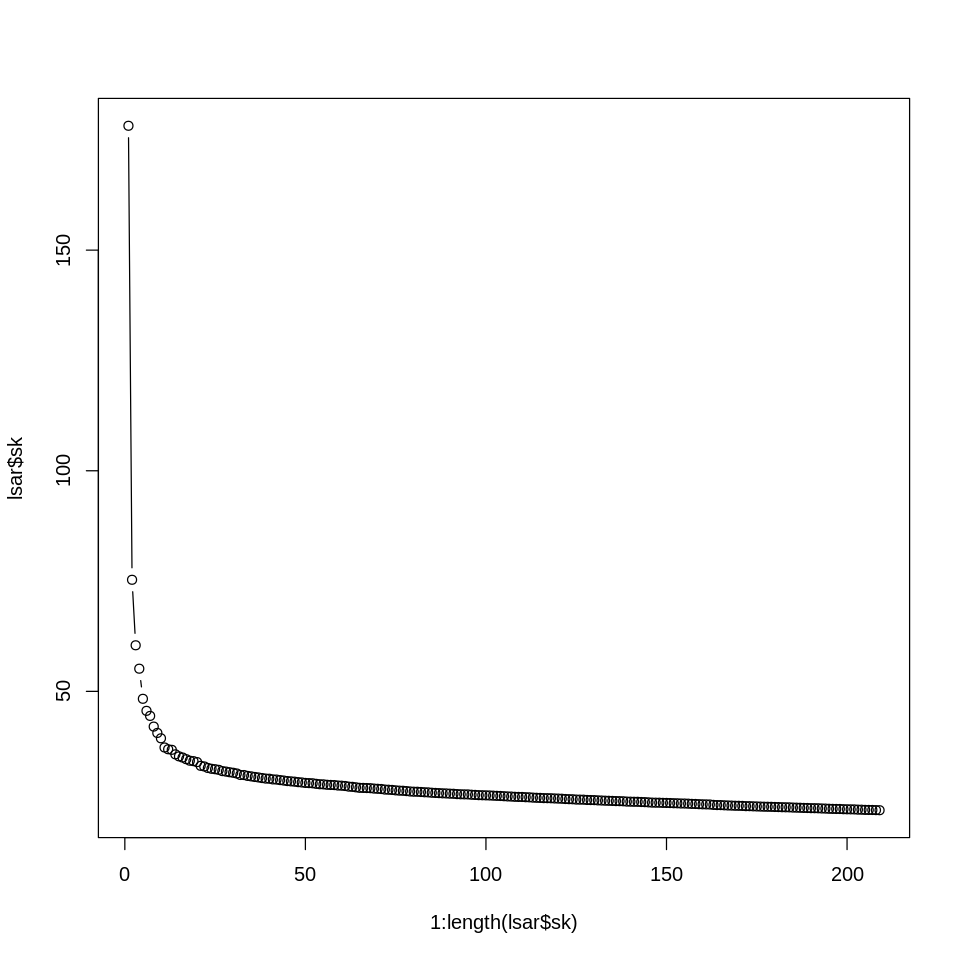

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
plot(1:length(lsar$sk), lsar$sk, type="b")

All operations performed in the latent semantic space have to consider the different relevance of each column, therefore we compute the terms and the documents matrices re-weighted by the eigenvalues.

In [ ]:
# Let's compute the two matrices of terms and docs, weighted by the eigenvalues
tls <- lsar$tk %*% diag(lsar$sk)
dls <- lsar$dk %*% diag(lsar$sk)

Given that the norm of each term represents the importance of that word in the latent space, we should compute the norms of all terms and we add it as a column to the terms matrix. In this way we will be able to use this information in some future operations.

In [ ]:
# Compute the norm for each term
norm_terms_lsa <- apply(tls, 1, norm_vec)

# Add the column of the norms to the matrix tls
tls_norm_terms = cbind(tls, norm_terms_lsa)

We can explore the top words in terms of norm and you can see that among the most relevant, there are some words in a language different from english, that's because we have a lot of english songs and few songs of other countries.

In [ ]:
cat("The norm of the word 'pour' is", norm_terms_lsa['pour'])
cat("\nThe norm of the word 'que' is", norm_terms_lsa['que'])

The norm of the word 'pour' is 20.556
The norm of the word 'que' is 52.00892

In [ ]:
sorted_norms <- sort(norm_terms_lsa, decreasing=T)
cat("The terms with the highest norm are:\n")
cat(paste(names(sorted_norms[1:15]), unname(sorted_norms[1:15]), sep=':', collapse="\n"))

The terms with the highest norm are:
que:52.0089227274382
love:46.3044922444933
babi:44.7335241759684
yeah:43.5707575894378
get:39.6995548558896
wanna:39.1662969078268
got:38.9146353366454
gonna:38.8757829514638
und:38.5774786847751
hey:38.2621387796054
let:38.0355959233098
want:37.8291567282837
girl:37.551011465529
come:36.3953069923814
like:35.8102619719151

As seen before, the first eigenvalues are the ones with the highest values, let's try to plot the words considering the first two latent dimensions. 

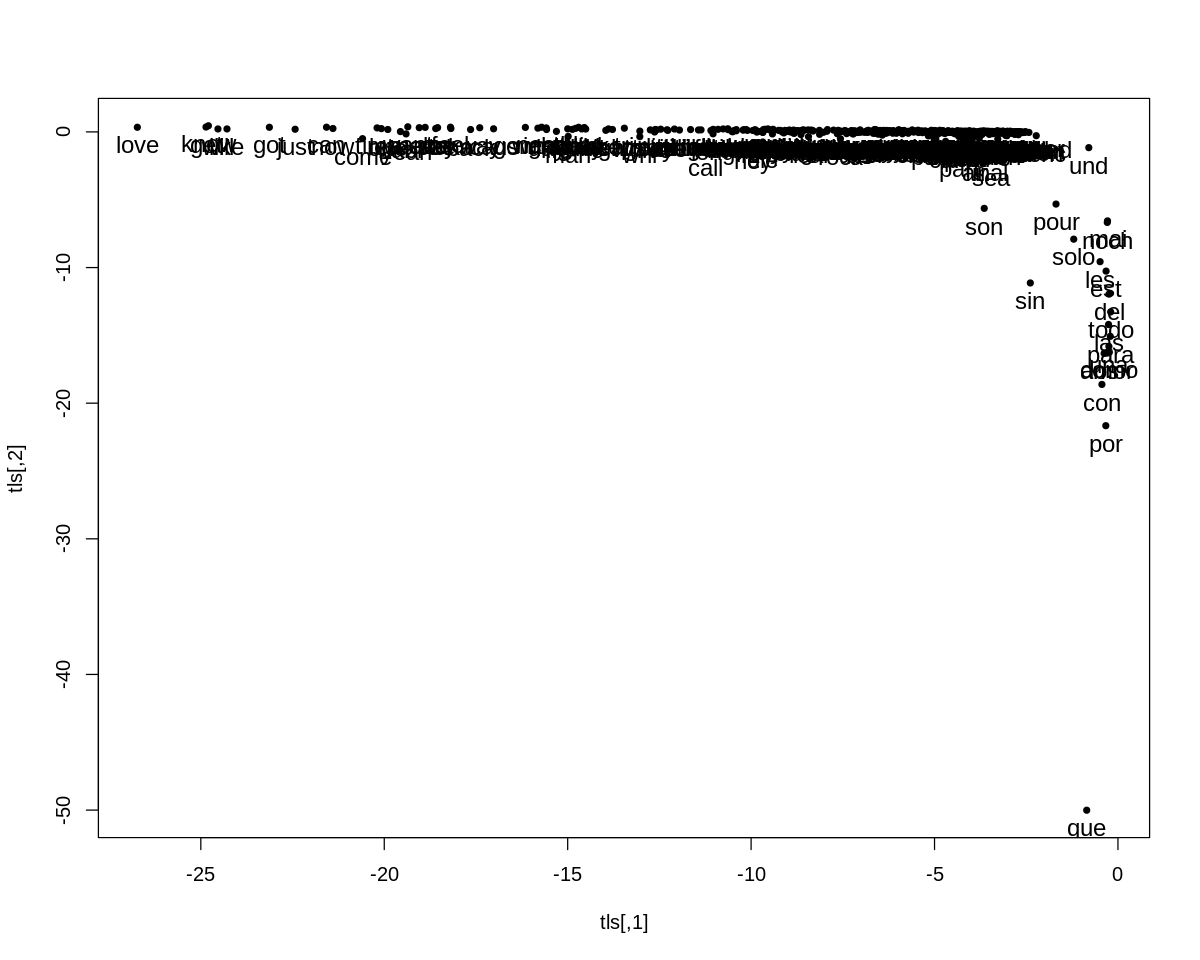

In [ ]:
# Graphic representation of terms using the first two latent dimensions
options(repr.plot.width=10, repr.plot.height=8)
plot(tls, pch=20)
text(tls, labels=words, cex=1.2, pos=1)

We have a lot of words close to the origin, thus they don't contain relevant information. The first latent dimension, with the corresponding eigenvalue, dominates the second dimension, that's why we have a compressed space along one dimension. 

Moreover let's try to remove some terms to have a clearer graph, selecting only the terms with a norm higher than a given threshold.

In [ ]:
# We added one column at the end so we take length + 1
last_col <- length(lsar$sk)+1

# Computing the mean of the norm for the terms in order to set a suitable threshold
cat("The mean for the norm of the terms is", mean(tls_norm_terms[,last_col]))

The mean for the norm of the terms is 17.04203

In [ ]:
# Subset of terms with norm > 18 (the last column contains the norms)
tls_reduced <- subset(tls_norm_terms, norm_terms_lsa > 18.0)[,-last_col]

cat("After the reduction we have", nrow(tls_reduced), "words.")

After the reduction we have 226 words.

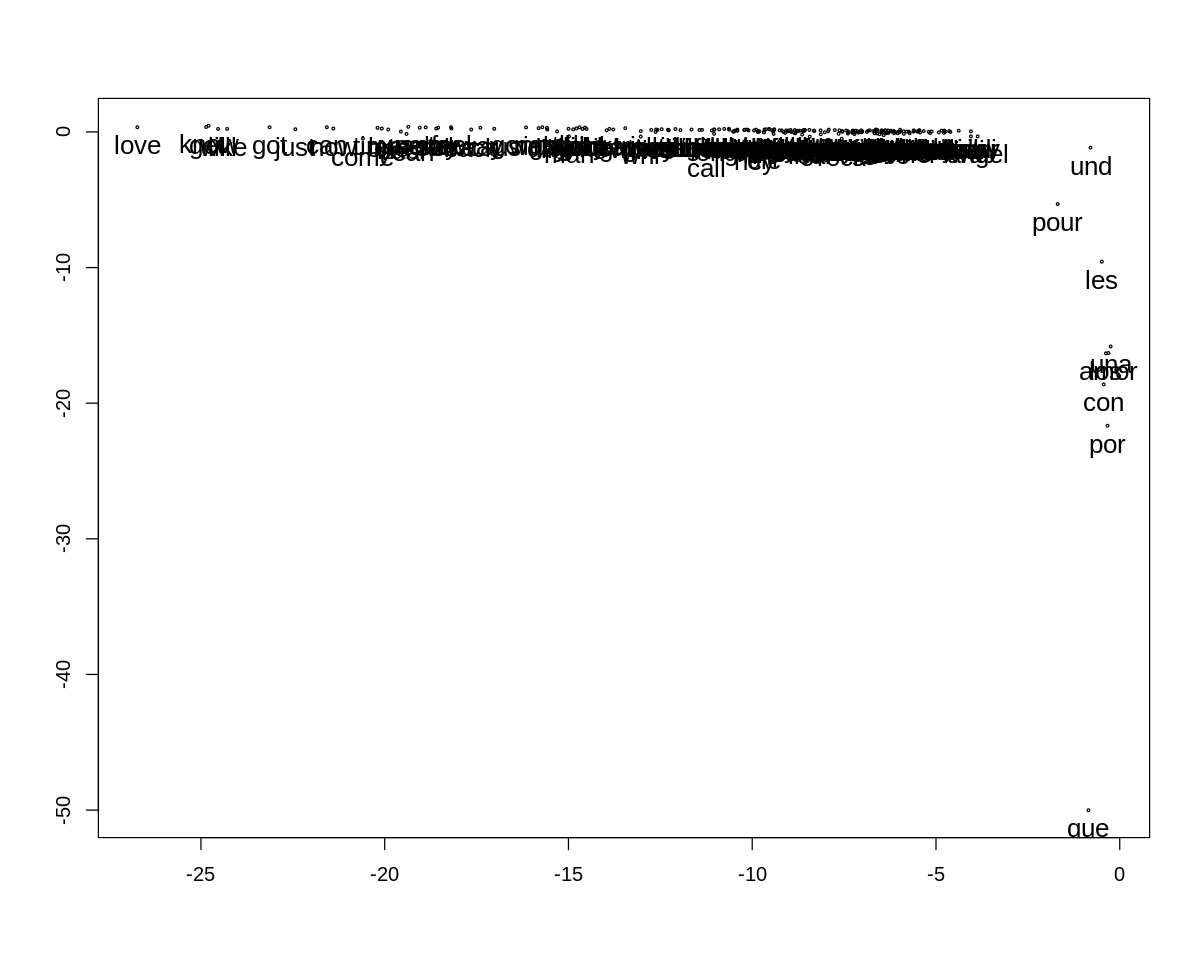

In [ ]:
# Representation of this terms subset using the first two latent dimensions
options(repr.plot.width=10, repr.plot.height=8)
plot(tls_reduced, pch=21, cex=0.3)
# Change the rownames otherwise mislabeled
text(tls_reduced, labels=rownames(tls_reduced), cex=1.3, pos=1)

We also plot the documents to check their distribution and we can conclude that it's similar to the one of the terms. 

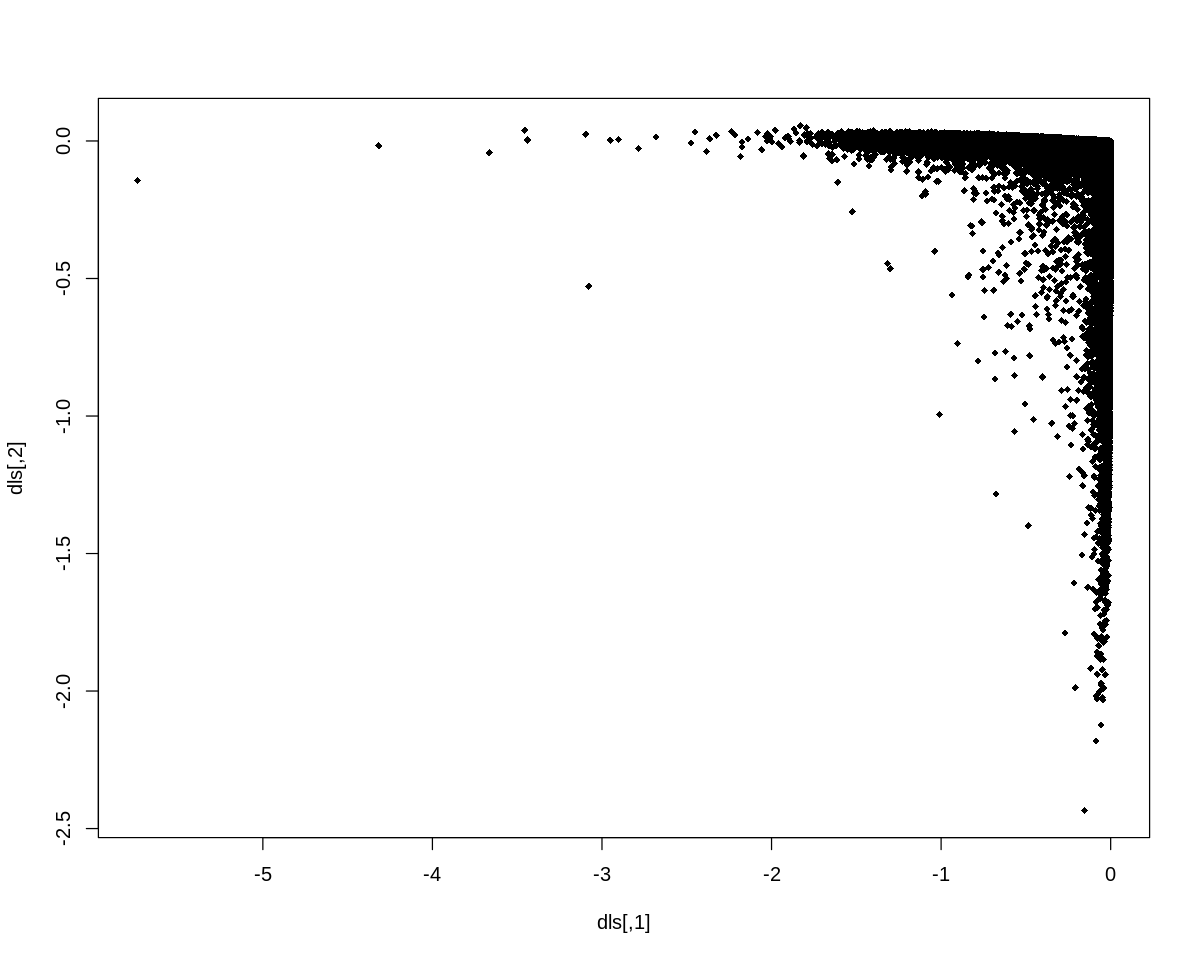

In [ ]:
# Graph of the documents using the first two latent dimensions
plot(dls, pch=18, cex=0.8)

The previous problem still appears, the documents are compressed in a narrow space and the majority of data is following a specific direction and it's within an area. It would be better if documents and words would be as distributed as possible, radially from the origin. In cosine similarity, this alignment means that there are correlations and the elements are correlated with each other.

Let's try to display the elements with the second and third latent dimensions, the distance between these 2 eigenvalues is lower than the one between the first and the second eigenvalues.

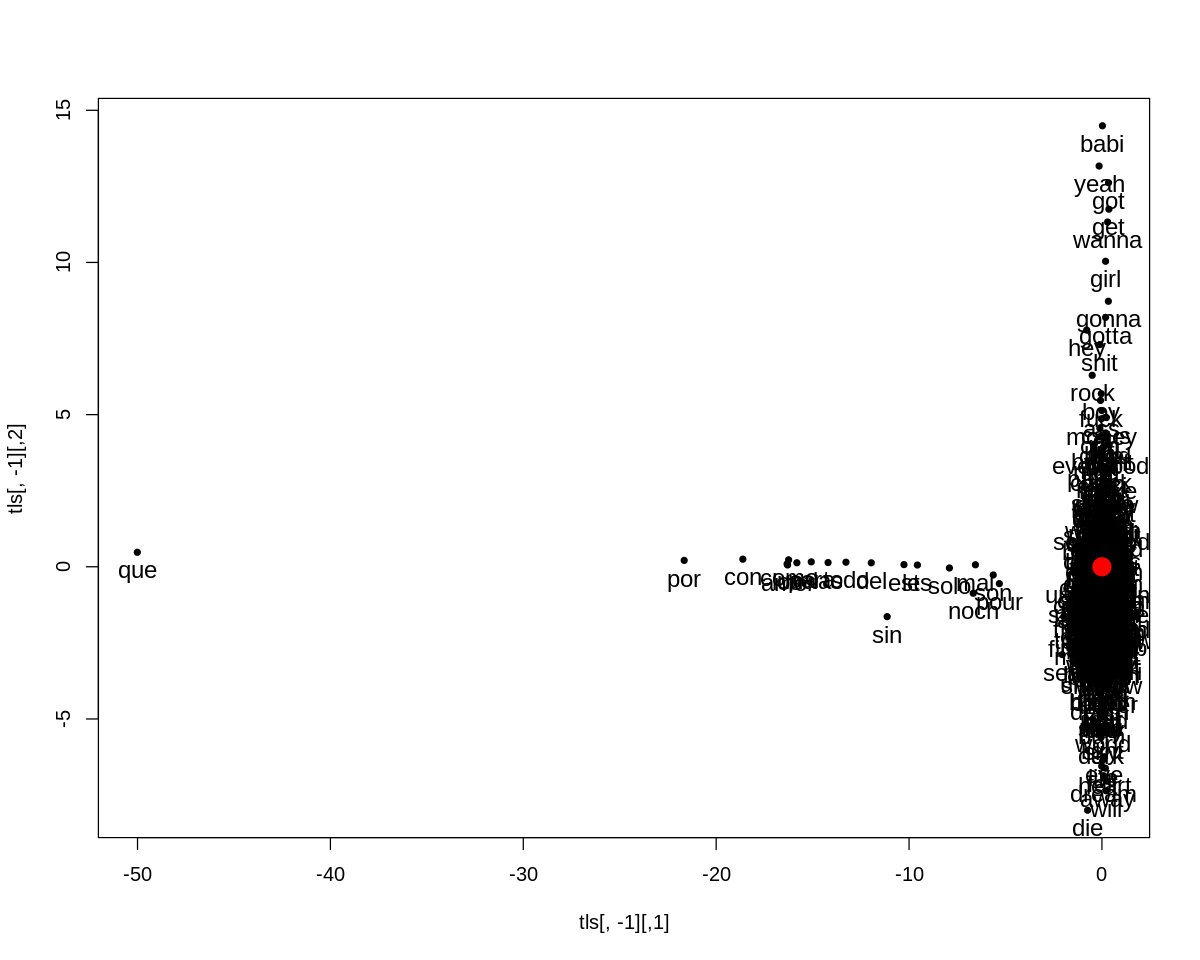

In [ ]:
# Graph representation of the terms using the second and third latent variables
options(repr.plot.width=10, repr.plot.height=8)

# -1 removes the first latent dimensions in order to display 2° and 3°
plot(tls[,-1], pch=20) 
text(tls[,-1], labels=words, cex=1.2, pos=1)

# Draw the origin 0,0 of the cartesian plane
points(0, 0, pch=20, cex=3, col="red")

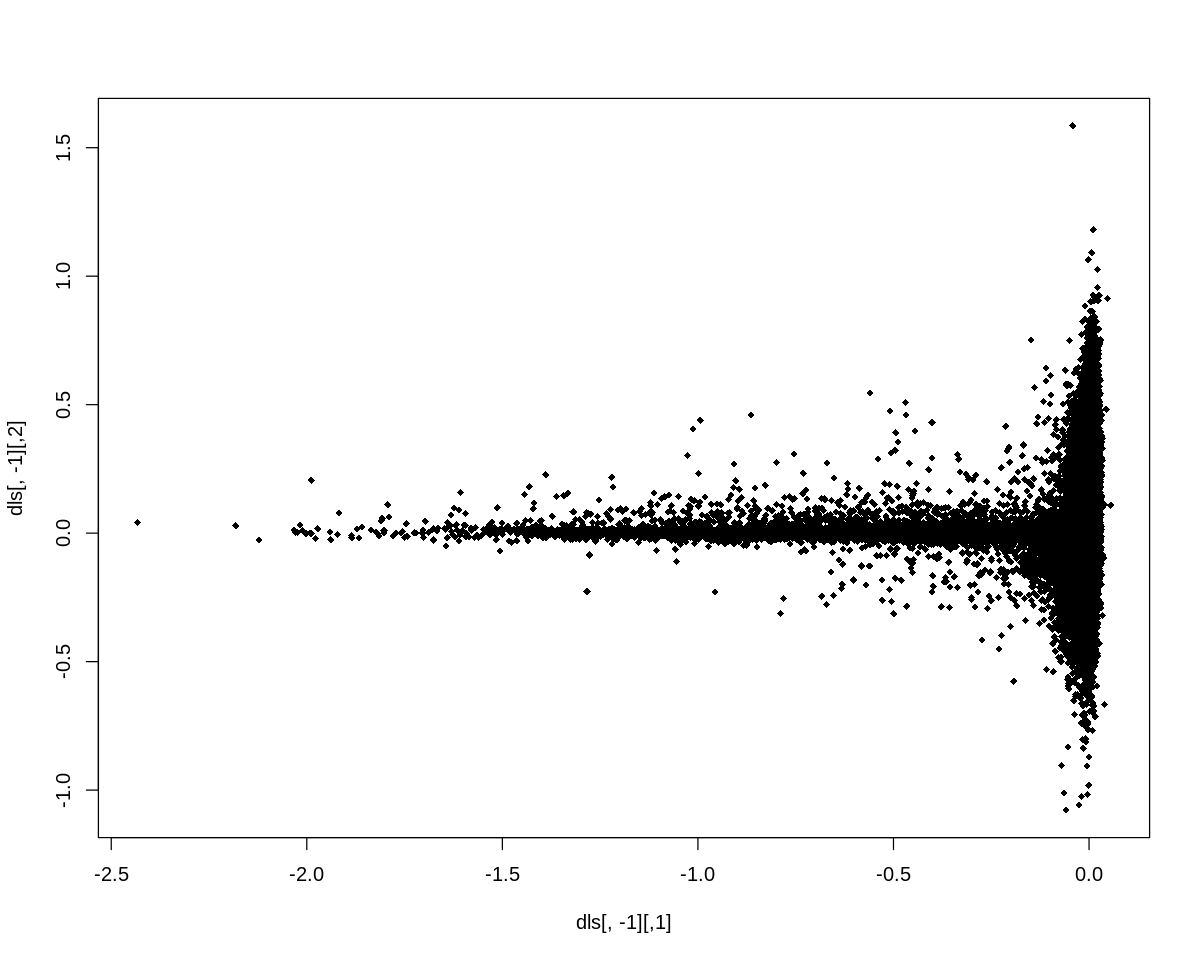

In [ ]:
# Graph of docs using 2° and 3° latent dimensions
plot(dls[,-1], pch=18, cex=0.8)

Now, the words and documents are more distributed in several directions, because the values of the considered eigenvalues are more similar and therefore neither dimension compresses the other.

Let's try to plot also the third and fourth latent dimensions to confirm the previous idea.

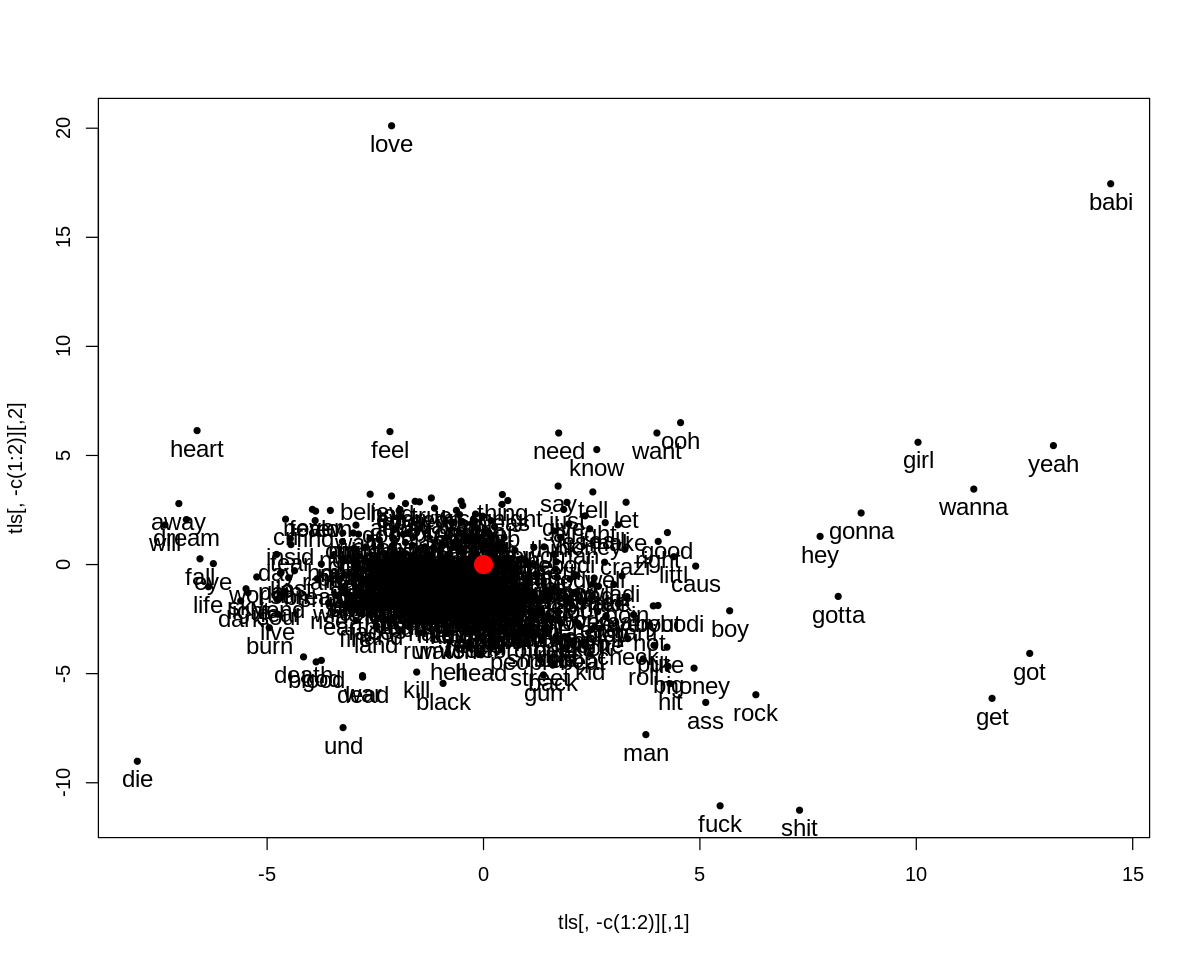

In [ ]:
# Graph representation of the terms using the third and fourth latent variables
options(repr.plot.width=10, repr.plot.height=8)

# -c(1:2) removes the first latent dimensions in order to display 3° and 4°
plot(tls[,-c(1:2)], pch=20) 
text(tls[,-c(1:2)], labels=words, cex=1.2, pos=1)

# Draw the origin 0,0 of the cartesian plane
points(0, 0, pch=20, cex=3, col="red")

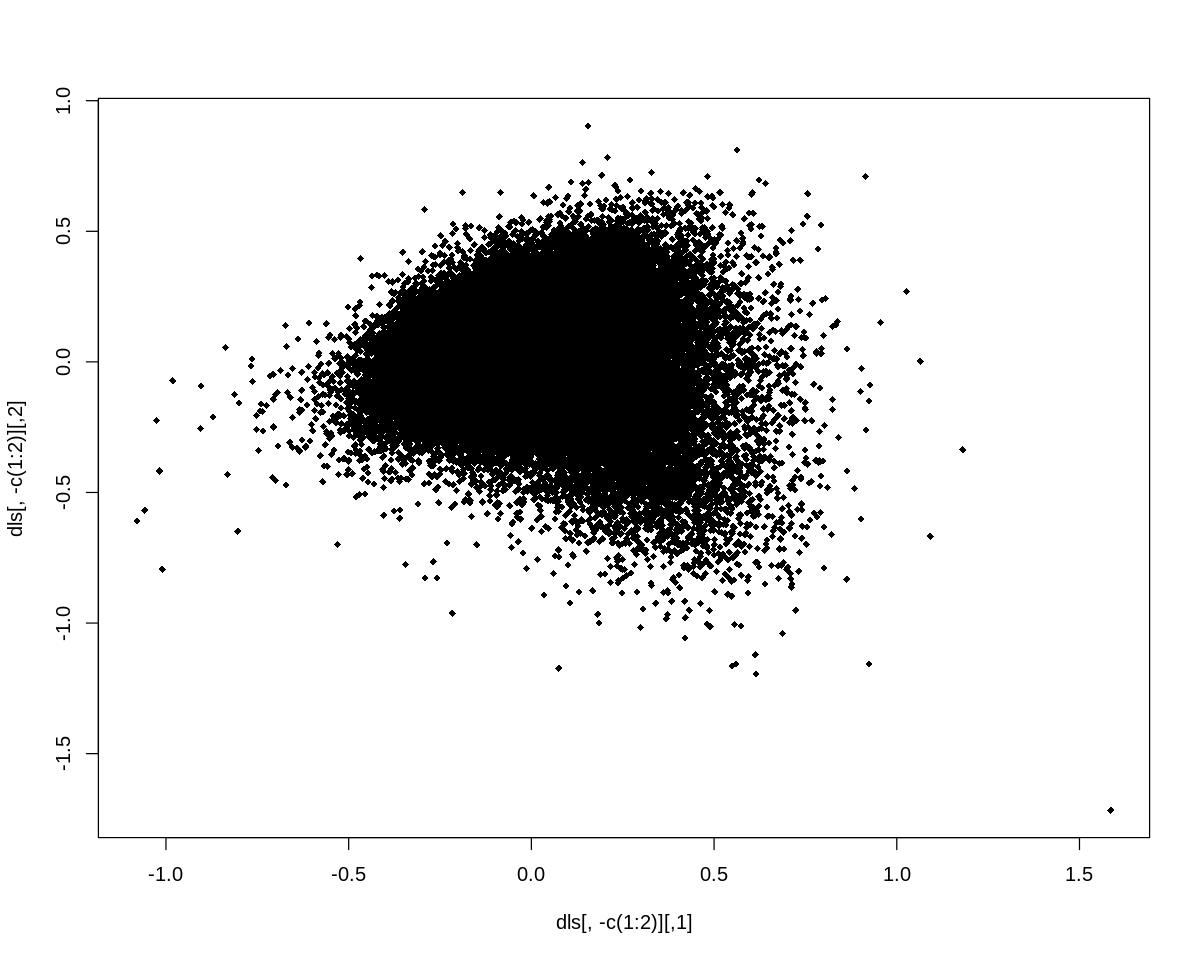

In [ ]:
# Graph of docs using 2° and 3° latent dimensions
plot(dls[,-c(1:2)], pch=18, cex=0.8)

As you can see, the elements are now distributed almost in a circle, therefore we will consider these dimensions in the following experiments.

## Analysis of song genres

In [13]:
install.packages('dplyr', quiet=T)
library('dplyr')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Let's print the most represented genres and check how many elements we have for the first 10 genres.

In [ ]:
genres <- songs_df$tag

genre_10 <- summary(as.factor(genres))[1:10]
cat(paste(names(genre_10), genre_10, sep=":", collapse='\n'))

rock:13476
pop:5794
indie:5526
country:4043
punk:3538
soul:2493
folk:2473
80s:2298
classic rock:2047
alternative:1949

In [ ]:
cat("The", genre_10['rock']*100/length(genres),"% of songs are rock.")

The 8.786766 % of songs are rock.

The total number of genres is very high but for the purpose of the project, we can restrict them to the top 10 and we create a color mapping for these ones in order to make a plot.

In [ ]:
# Take only the songs that are among the top 10 genres
top_genre_rows <- genres %in% names(genre_10)

# Creates color mapping to plot the genres
color_mapping <- recode(genres, rock="red", pop="blue", indie="green", country="burlywood4",
                        punk="blueviolet", soul="aquamarine", folk="deeppink", "80s"="chartreuse",
                        "classic rock"="darkgoldenrod1", alternative="deepskyblue", .default='black')

In the following cell we keep only the elements from the genre list that belong to one of the top 10 music styles.

In [ ]:
# Conversion of the class names to colors in order to distinguish in the graph the genre of the songs.
genre_colors <- as.vector(color_mapping)[top_genre_rows]

head(genre_colors[1:10])
head(genres[top_genre_rows][1:10])

[1] "chartreuse"     "darkgoldenrod1" "green"          "green"         
[5] "green"          "red"

[1] "80s"          "classic rock" "indie"        "indie"        "indie"       
[6] "rock"

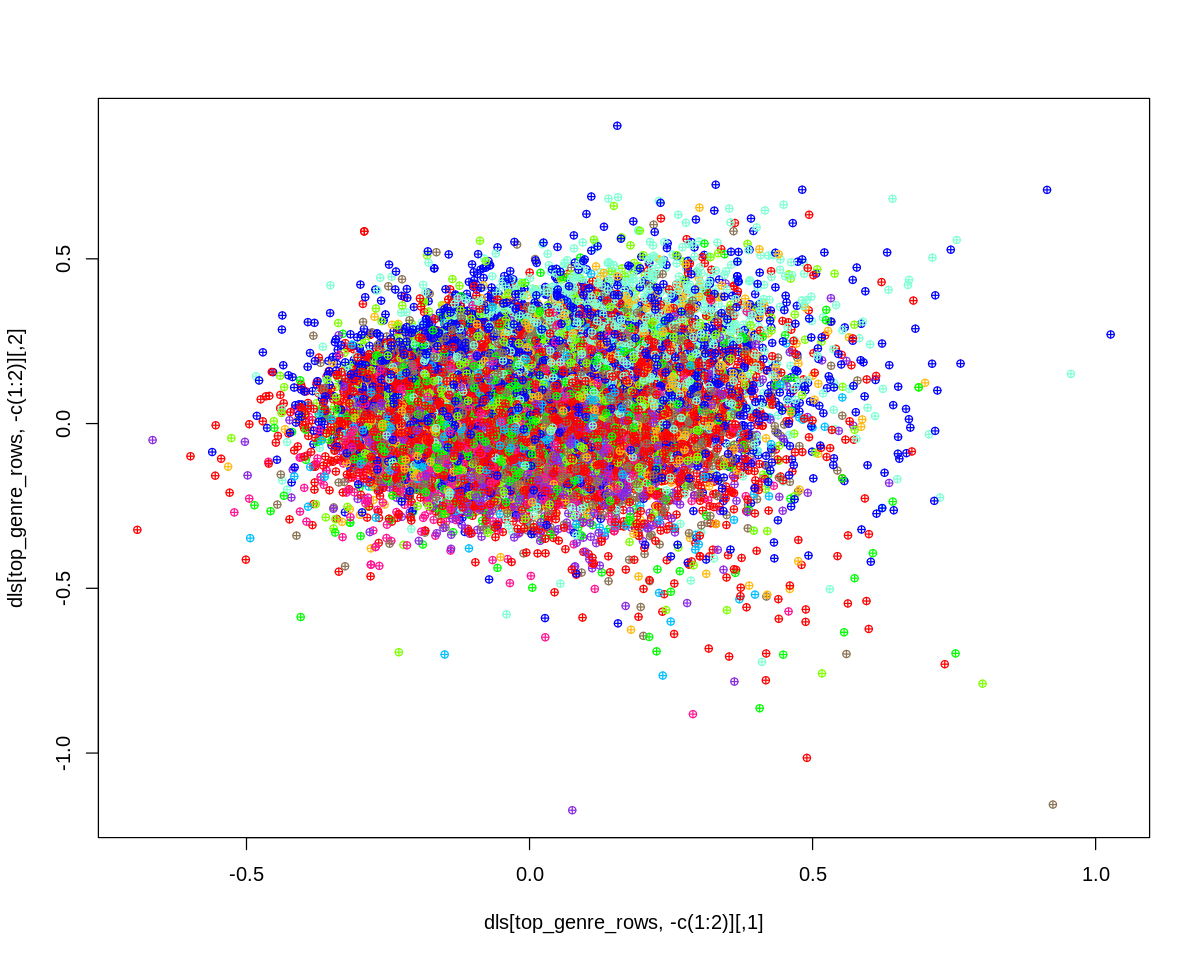

In [ ]:
# Let's plot only the top genres to better understand the distribution removing noise
options(repr.plot.width=10, repr.plot.height=8)
plot(dls[top_genre_rows, -c(1:2)], pch=10, cex=0.8, col=genre_colors)

We cannot deduct a lot of information from the graph, probably because in songs of different genres the artists can still use similar words and only change the melody. Moreover, we have a lot of rock and pop songs, therefore it's more likely to find a lot of different words for those genres than for the others. 

Let's try to restrict the analysis to four genres that can be considered quite interesting, soul songs are different from classic rock ones and classic rock songs may have some similarities with country music. Alternative is basically different from others but with some common points.

In [ ]:
# Take some different genres
genre_4_rows <- genres %in% c('soul', 'country', 'classic rock', 'alternative')

genre_4_colors = as.vector(color_mapping)[genre_4_rows]

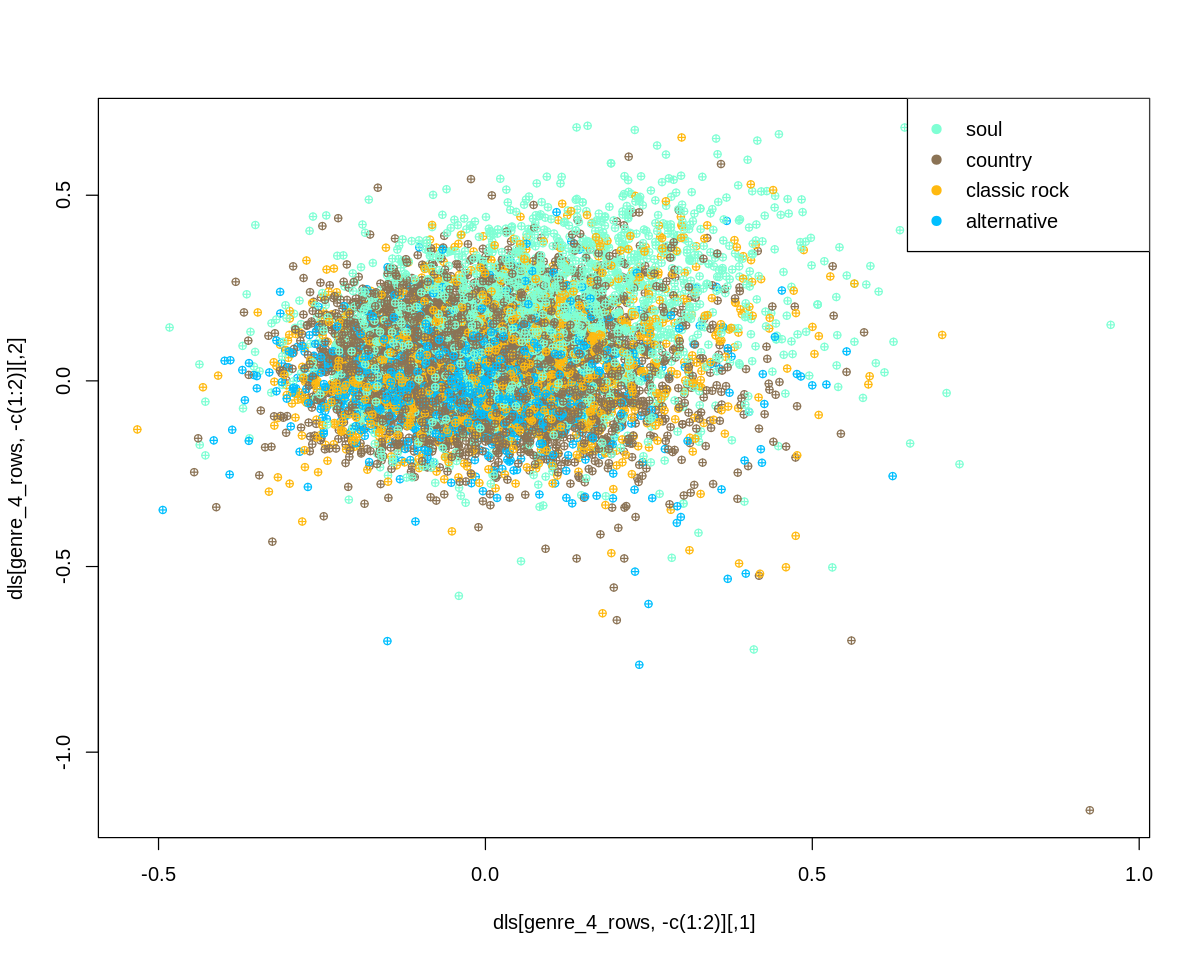

In [ ]:
# Let's plot only some genres to better understand the distribution
options(repr.plot.width=10, repr.plot.height=8)
plot(dls[genre_4_rows, -c(1:2)], pch=10, cex=0.8, col=genre_4_colors)
legend(x="topright", legend=c("soul", "country", "classic rock", 'alternative'), col=c("aquamarine", "burlywood4", "darkgoldenrod1","deepskyblue"), pch=19) 

As you can see the soul is quite expanded at the top of the graph, while classic rock and country, that are related genres, are more compacted. 

In [ ]:
# Retrieve only top 135 words, considering the norm, to avoid confusion in the graph
top_terms <- names(sort(norm_terms_lsa, decreasing=T)[1:135])
top_terms_rows <- rownames(tls) %in% top_terms

In [ ]:
# Definition and application of the function for the normalization of terms and docs vectors 
# indeed the vectors tls and dls are not normal because achieved by the product with sk
norm_rows <- function(x) x / apply(x, 1, norm, "2")
tlsn <- norm_rows(tls)
dlsn <- norm_rows(dls)

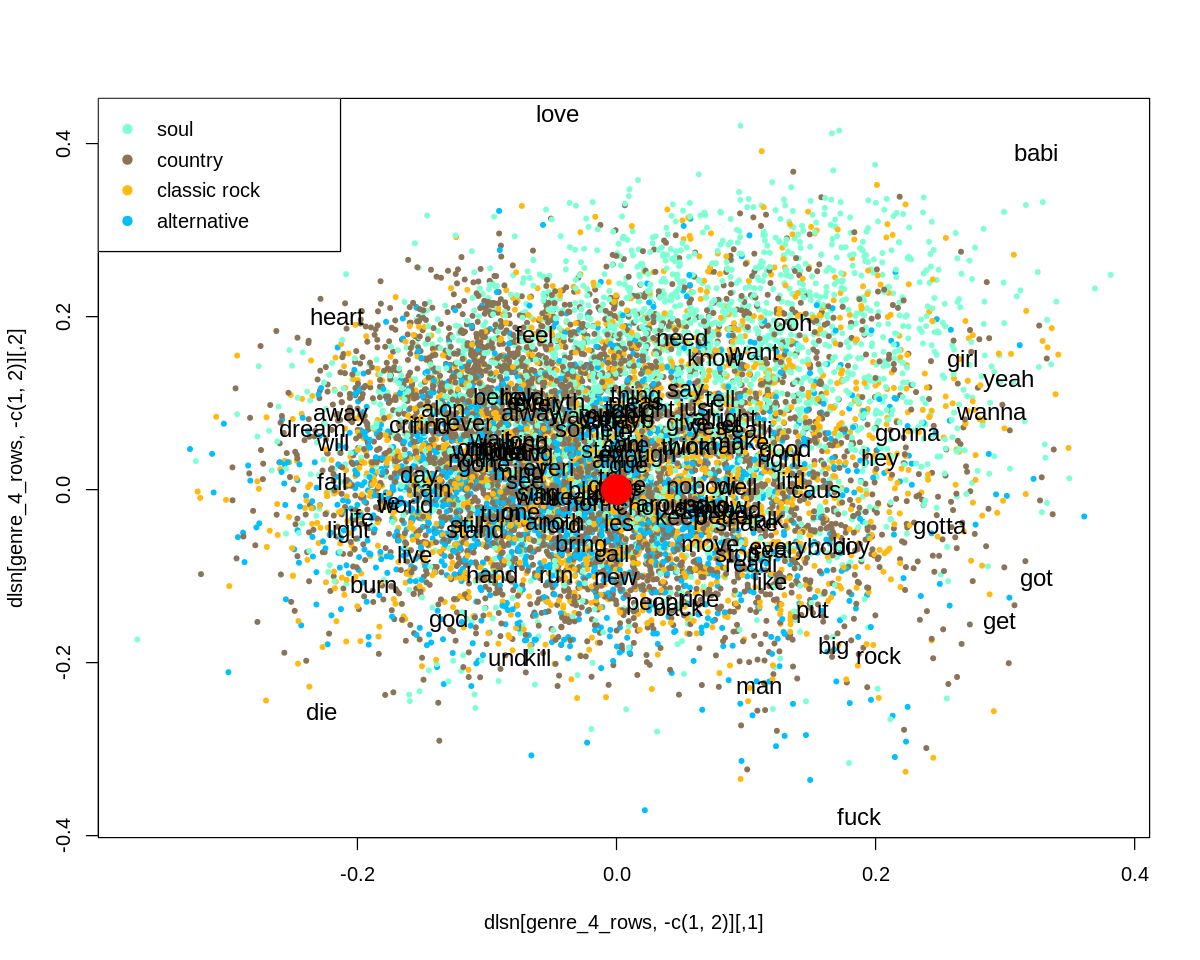

In [ ]:
# New graph with normalized vectors of terms and docs
options(repr.plot.width=10, repr.plot.height=8)
plot(dlsn[genre_4_rows,-c(1,2)], pch=20, cex=0.8, col=genre_4_colors)
text(tlsn[top_terms_rows,-c(1,2)], labels=words[top_terms_rows], cex=1.2)
points(0, 0, pch=20, cex=5, col="red")
legend(x="topleft", legend=c("soul", "country", "classic rock", 'alternative'), col=c("aquamarine", "burlywood4", "darkgoldenrod1","deepskyblue"), pch=19) 

If you have the document and word embeddings and you want to represent them in 2 dimensions, you have "to cut" the vectors but there is no guarantee to capture most of relevant information, you are simply looking at a specific projection (keeping the first 2 dimensions for example). The distribution that you show may be wrong with respect to the real distribution. 

Using the LSA approach, you are sure that the first dimensions capture much more information than the others, therefore the problem is less relevant.

At this point, we want to check if there is a correlation between a characteristic word of 'country' with songs of this genre.

## Chi-square tests to observe correlation between different words and genres

We test the term 'heart', it is far from the other words in the graph and close to some 'country' songs, thus it may be interesting. Let's verify objectively if exits a lexical correlation between the term and some genres in the original space tdm, i.e. not-lsa.

In this case, we consider only the docs containing the term and we perform the analysis using the chi-square test.

In [ ]:
# We compute the contingency matrix
heart_co <- table(tdm["heart",] > 0, genres=="country")

dimnames(heart_co) <- list(heart=c("No", "Yes"), "country"=c("No", "Yes"))
# This function computes automatically the expected frequencies (i.e. theoretical) 
# from the observed ones. We don't need to correct because we don't have small values.
chisq_test_co = chisq.test(heart_co, correct=FALSE) 

# chi-square distribution is simply the summation of several squared variables and
# they are normally distributed (this is the theoretical squared distribution).
chisq_test_co


	Pearson's Chi-squared test

data:  heart_co
X-squared = 573.61, df = 1, p-value < 2.2e-16


In [ ]:
# Expected values and observed values from the chisquare test 
chisq_test_co$expected
chisq_test_co$observed

,No,Yes
No,122531.42,3317.5814
Yes,26792.58,725.4186


     country
heart     No    Yes
  No  123108   2741
  Yes  26216   1302

As you can see, the term is very correlated to the genre considering the original matrix. Just from the deviation between the expected and the observed values for "Yes"-"Yes" you may expect a high chi-square and a small p-value. 

To show another example, the p-value for the term 'heart', considering the 'classic rock' genre is very high.

In [ ]:
# We compute the contingency matrix
heart_cr <- table(tdm["heart",] > 0, genres=="classic rock")

dimnames(heart_cr) <- list(heart=c("No", "Yes"), "classic rock"=c("No", "Yes"))

chisq_test_cr = chisq.test(heart_cr, correct=FALSE) 
chisq_test_cr


	Pearson's Chi-squared test

data:  heart_cr
X-squared = 0.15165, df = 1, p-value = 0.697



In order to refine the query and to get a more precise hint about the correlation between the term and the genre, we should first check which are the most similar terms to 'heart' and then we will perform the Chi-squared test again.

### Expand the query with semantically related terms

As said in the previous cell, we cannot conclude that a relation exists between the term and the genre simply considering that test. Therefore, we will add a semantically similar term to the query in order to have a better intuition about the relationship. 

In [ ]:
# Find the semantically closest terms to heart in the LSA space
similar5 <- associate(tls[,3:4], "heart", threshold=0.8)[1:5]
cat("The 5 most similar terms to 'heart':\n", names(similar5),"\n",similar5)

# Check the norm
tmp_norm <- sort(norm_terms_lsa, decreasing=T)
cat("\n\nThe value of the norm for:\n", names(similar5))
data.frame(tmp_norm, row.names=names(tmp_norm))[names(similar5),]

The 5 most similar terms to 'heart':
 knew anymor smile long help 
 0.9999502 0.9992847 0.9982816 0.9961437 0.995572

The value of the norm for:
 knew anymor smile long help

[1] 11.139146  9.385861 13.800349 29.545694 24.244627

Given that all these 5 words are very similar, but the norms are quite different, it is reasonable to take the term with the highest norm that is 'long'.

In [ ]:
# Let's verify if also the couple "heart long" is objectively correlated to the classic rock genre
heart_long_co <- table(tdm["heart",]>0 & tdm["long",]>0, genres=="country")
dimnames(heart_long_co) <- list("heart long"= c("No", "Yes"), country=c("No", "Yes"))
chisqtest = chisq.test(heart_long_co, correct=FALSE)

chisqtest


	Pearson's Chi-squared test

data:  heart_long_co
X-squared = 266.57, df = 1, p-value < 2.2e-16


The p-value is very low, therefore the query is related to the genre 'country', but we will also perform a semantic analysis in the next cells.

We also want to consider the most similar terms computed on the second and third latent dimensions, in order to check if some different words appear.

In [ ]:
# Find the semantically closest terms to heart in the LSA space
similar5 <- associate(tls[,2:3], "heart", threshold=0.8)[1:5]
cat("The 5 most similar terms to 'heart':\n", names(similar5), "\n", similar5)

# Check the norm
tmp_norm <- sort(norm_terms_lsa, decreasing=T)
cat("\n\nThe value of the norm for:\n", names(similar5))
data.frame(tmp_norm, row.names=names(tmp_norm))[names(similar5),]

The 5 most similar terms to 'heart':
 word clear hide behind insid 
 1 0.9999999 0.9999999 0.9999997 0.9999987

The value of the norm for:
 word clear hide behind insid

[1] 21.465272  5.537247 11.043440 12.477585 24.073976

The most similar term is 'word' and it has a quite high norm, but 'insid' seems to be more related to the original query, therefore we should consider it for performing the Chi-squared test.

In [ ]:
# Let's verify if the couple "heart insid" is correlated to the country genre
heart_insid_co <- table(tdm["heart",]>0 & tdm["insid",]>0, genres=="country")
dimnames(heart_insid_co) <- list("heart insid"= c("No", "Yes"), "country"=c("No", "Yes"))
chisqtest = chisq.test(heart_insid_co, correct=FALSE)

chisqtest


	Pearson's Chi-squared test

data:  heart_insid_co
X-squared = 10.212, df = 1, p-value = 0.001395


In this case the p-value is quite high, this means that the query 'heart insid' seems not to be much correlated to the genre 'country'.

### Use LSA to capture semantic meaning

Up to now, we are basing our analysis on lexical matching, let's try to exploit LSA in order to capture semantic meaning. We want to see if there is a semantic correlation between the couple of terms and the genre.

In [ ]:
# To peform this analysis let's transform the query "heart long" in a doc and do the fold_in in the LSA space
heart_long_query <- "heart long"
heart_long_vec <- query(heart_long_query, words)
heart_long_le <- lw_logtf(heart_long_vec) * (1-entropy(tdm))
heart_long_ls <- t(heart_long_le) %*% lsar$tk
heart_long_ls

HEART LONG,-0.01803618,2.256224e-05,-0.01799156,0.01749782,-0.0007446085,0.01162711,-0.0007984957,-0.005325088,-0.006002214,-0.008630381,⋯,-0.00228596,-0.003072194,0.005101935,0.009302794,-0.002673186,0.001241777,0.0005365242,0.0149757,0.0005650952,-0.004544114


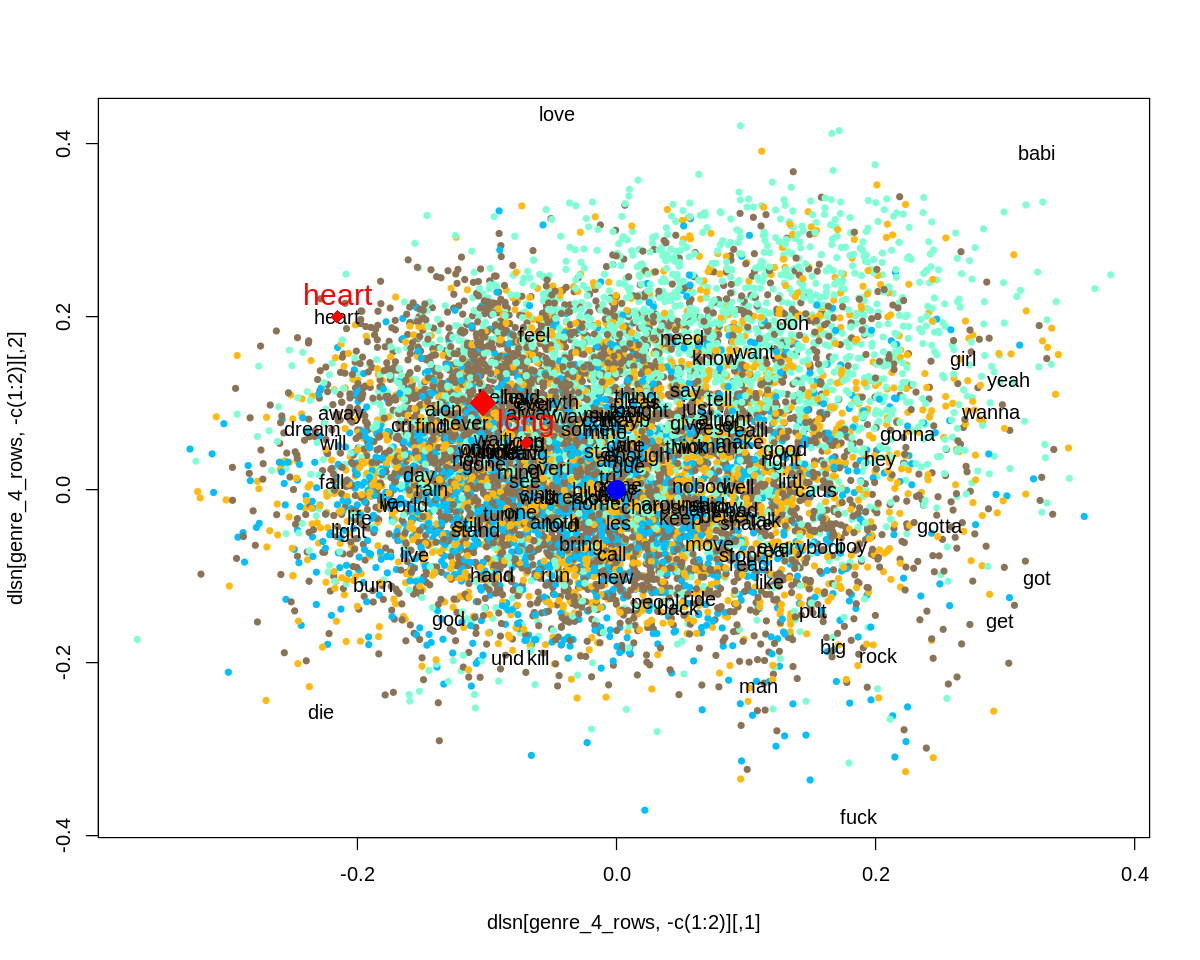

In [ ]:
# Graph of the terms, docs and query in the LSA space using the dimensions 3 and 4
plot(dlsn[genre_4_rows,-c(1:2)], pch=20, cex=1, col=genre_4_colors)
text(tlsn[top_terms_rows,-c(1:2)], labels=words[top_terms_rows], cex=1)
points(0, 0, pch=20, cex=3, col="blue") 

heart_long_ls_n <- norm_rows(heart_long_ls)
points(heart_long_ls_n[3], heart_long_ls_n[4], cex=3, pch=18, col="red")
# Set the text of the 2 terms in order to visualize better
heart_word <- tlsn['heart',]
long_word <- tlsn['long',]

text(heart_word[3], heart_word[4], labels='heart', cex=1.5, col="red", pos=3)
points(heart_word[3], heart_word[4], cex=1.5, pch=18, col="red")
text(long_word[3], long_word[4], labels='long', cex=1.5, col="red", pos=3)
points(long_word[3], long_word[4], cex=1.5, pch=18, col="red")

In [ ]:
# Define the function that returns a vector of cosine similarities between vector Q and the rows of matrix X
cosines <- function(X, Q) apply(X, 1, cosine, as.vector(Q))

# Function that returns the indices of the N higher values in X 
top <- function(X, N) order(X, decreasing=TRUE)[1:N]

Now we can use these functions to compute the most similar songs to a given input, the query 'heart long' in this case.

In [ ]:
# Top 10 songs that are more semantically similar to the query, considering only 3° and 4° latent dimensions
sim_10_songs <- top(cosines(dls[,3:4], heart_long_ls[3:4]), 10)

# List the 10 songs
songs_df[sim_10_songs, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
22193,I'm Going Home,The Kingston Trio,Kingston Trio
86321,Some Say,Kristian Leontiou,pop
70880,Vertigo,The Libertines,indie
33200,Summer Rain,ATB,trance
82275,Under Your Wings And Into Your Arms (live),My Dying Bride,doom metal
79308,The Voice Within,Christina Aguilera,pop
96117,Introduction (Album Version),Matchbook Romance,introduction
113366,You & Me Song,The Wannadies,pop
75793,These Three Words,Trijntje Oosterhuis,pop


We printed the lyrics for some songs but given that the text is stemmed and in a bag of words format we are not able to do a sensible examination.

In [ ]:
as.list(songs_df[c(22193, 86321, 75793), 'lyrics'])

[[1]]
[1] "i i i i i i i i i i i the the the to and and and and a a me me me me not not not my my of that do do am am am will will will no be have love know know know know there go go go up they they down down make would at her her her her where gonna who through well find hand then call everi alway home home home hold end friend friend stop peopl peopl chorus chorus chorus watch lord open work work matter though somebodi river repeat somewher wave mountain someday welcom golden field wander twice gentl highway folk settl waitin valley valley journey california driven glide"

[[2]]
[1] "i i i i i i i i i i i i the the the the the the the the the the the the the the the the the the the the you you you you you you you you you you you you you you you to to to to and and me me me in in in my my my my my my is is is your your your that that that that that that do do do do do do do on on on we we will will will will will will will no no be be be be be have have love love love love love love love love love love love love so but but but when time can can can can can can can can can can can can one one see see feel feel feel feel feel feel feel feel feel feel feel feel make way way way say say say say say say say say say day day where where more more tell live tri tri tri whi some some some some some some some some some alway alway head head stay chang soul sun sun show show peopl free free same fear fear fear today truth under under road road road reason reason memori whole clear clear clear answer summer summer troubl forgiv confront confront confront"

[[3]]
[1] "i i i i i i i the the the the the the the the the the you you you you you you you you you you you you you you you you you you to to to to to and and and and and and and and and and and and a a a not not not in in of your your that that that that will all for be be be be have love love love love love love love so know know know know this just when when when when when when time time time time time can go one one one they they they they they they they they was was was was never never from say say say say say say would would would ca away life life heart heart heart how could eye tell who through give or or or or whi an an an an then call alway alway alway alway alway did did them them them them has their their insid insid insid word word word word word word word much these these these these these these these these last last last last friend show lost name same tear true sweet sweet sweet smile smile smile ask son best kind kind kind took heard heard heard heard veri gave mother between yet yet brother darl father joy everyday surviv simpl simpl simpl famili sister taken taken 3 3 3 3 3 3 3 3 3 short short short ach ach ach daughter claim simpli instant mourn rejoic whom cent cherish"

As you can see, the majority of similar songs are not actually related to the 'country' genre, but considering the title and trying to understand the lyrics, maybe they have something similar to the given query. Moreover, each song can belong to more than one genre, thus this feature is not very reliable in the evaluation of the similarity between 2 songs.

We can also try to perform the search for the second query, "heart insid", considering this time the second and third latent dimensions (the dimensions whereby the term 'insid' was similar to 'heart').

In [ ]:
heart_insid_query <- "heart insid"
heart_insid_vec <- query(heart_insid_query, words)
heart_insid_le <- lw_logtf(heart_insid_vec) * (1-entropy(tdm))
heart_insid_ls <- t(heart_insid_le) %*% lsar$tk
heart_insid_ls

HEART INSID,-0.01663464,0.0005453268,-0.0243808,0.01667188,-0.001580213,0.003714169,0.001291449,0.02104649,-0.009748495,-0.005598132,⋯,0.0007830407,-0.005027497,4.356408e-05,0.01027805,-0.009585193,-0.002176118,-0.01013292,0.02419119,0.002565889,-0.01061965


In [ ]:
# Top 10 songs that are more semantically similar to the query, considering only 2° and 3° latent dimensions
sim_10_songs_hi <- top(cosines(dls[,2:3], heart_insid_ls[2:3]), 10)

# List the 10 songs
songs_df[sim_10_songs_hi, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
65767,How am I supposed to see the stars,Silje Nergaard,jazz
18194,Believe,The Smashing Pumpkins,rock
92734,I Saw The Light,Spoon,indie
13884,You & i,Krypteria,Gothic Metal
79001,Avantasia (Edit Version),Avantasia,symphonic metal
36392,The American Way,Sworn Enemy,hardcore
29861,Under Your Skin,Lizzy Borden,hard rock
98574,De-Luxe,Lush,shoegaze
49362,Traces,Enchant,Progressive rock


In [ ]:
as.list(songs_df[c(65767, 92734, 49362),'lyrics'])

[[1]]
[1] "i i i i i i i i i i i i i i i i i i i the the the the the the the the the the you you to to to to to to to to to to to to to and and and and and a me me me not not in my my my my is is of of of that that that that on are are am am am am am am am am am am am am am all for for for this this this but but but with when now can there up see see see see see see see see see see see say say say heart heart heart heart heart heart heart heart how how how how how how how how how how how how how eye eye thing who live onli mind an wo find around some light were walk ever lie has has has alon chang chang lost made start sky own mine far far far those those those star star star star star star mayb may rest feet cross cannot blame rais meant meant lift check prais corner suppos suppos suppos suppos suppos suppos suppos suppos suppos suppos suppos dice tall neck cost toss clay"

[[2]]
[1] "i i i i i i i i i i i i i i i i i i the the the the the the the the the the the the the the to to to to to and and and and and a me me me me me me me me it it it it not in in in in in my is of your that that do do do do am all all all all all be love love love love love so so can go they out feel back need thing world world world world world caus through again find find find some light light light light light light light hold off made break break da da ask wall wall part saw saw saw saw saw saw saw saw white white white felt felt felt felt m tight fell tie remind case whenev cream cream cream bind peel perman perman perman"

[[3]]
[1] "the the the the the the the the the the the the the the the to to to to to to to to and and and a a a a a a a a a a a a a a a a a a a me it it it it it it it not in in in in in in in is is is is is is is is is is is is is of of of of of of of of of of of of of of of that that that that do on on are are are are are we will will will will will will will be have have have have have know this this this this this this this this this this this this this this this but but but but what what what what what what what like like like like like like like like can can can can there there there there there there there there up up they they they out from take take take take take take day day day day day day day at at away away away away away away away away away here here here here here here here here here how how how how how could could could could look some hold hold them them them them them them cri their their their their someth someth someth someth someth place place place place place place place place place place place chang chang left left new new new new new new new start pain tear rain fear deep kind voic moon red such such wast sad happen happen happen happen speak tree repeat secret secret silenc sens sens whisper weak snow wash wash wash wash wash wash wash wash yesterday yesterday yesterday yesterday yesterday yesterday yesterday yesterday clean track wine refrain wit surround surround tide calm melt trace trace trace trace trace trace trace trace trace stain stain stain stain stain stain tale violenc violenc spill shed beach easili presenc halt harvest atmospher atmospher carpet dug"

To avoid the loss of information we should choose a latent space with more dimensions. First of all, we want to detect the knee points in the curvation function of the eigenvalues distribution. A knee point is a local minimum of the curvation radius of the iperbole function interpolating the data. 

We tried to take more dimensions to check if it makes us achieve better results for the 'heart long' query.

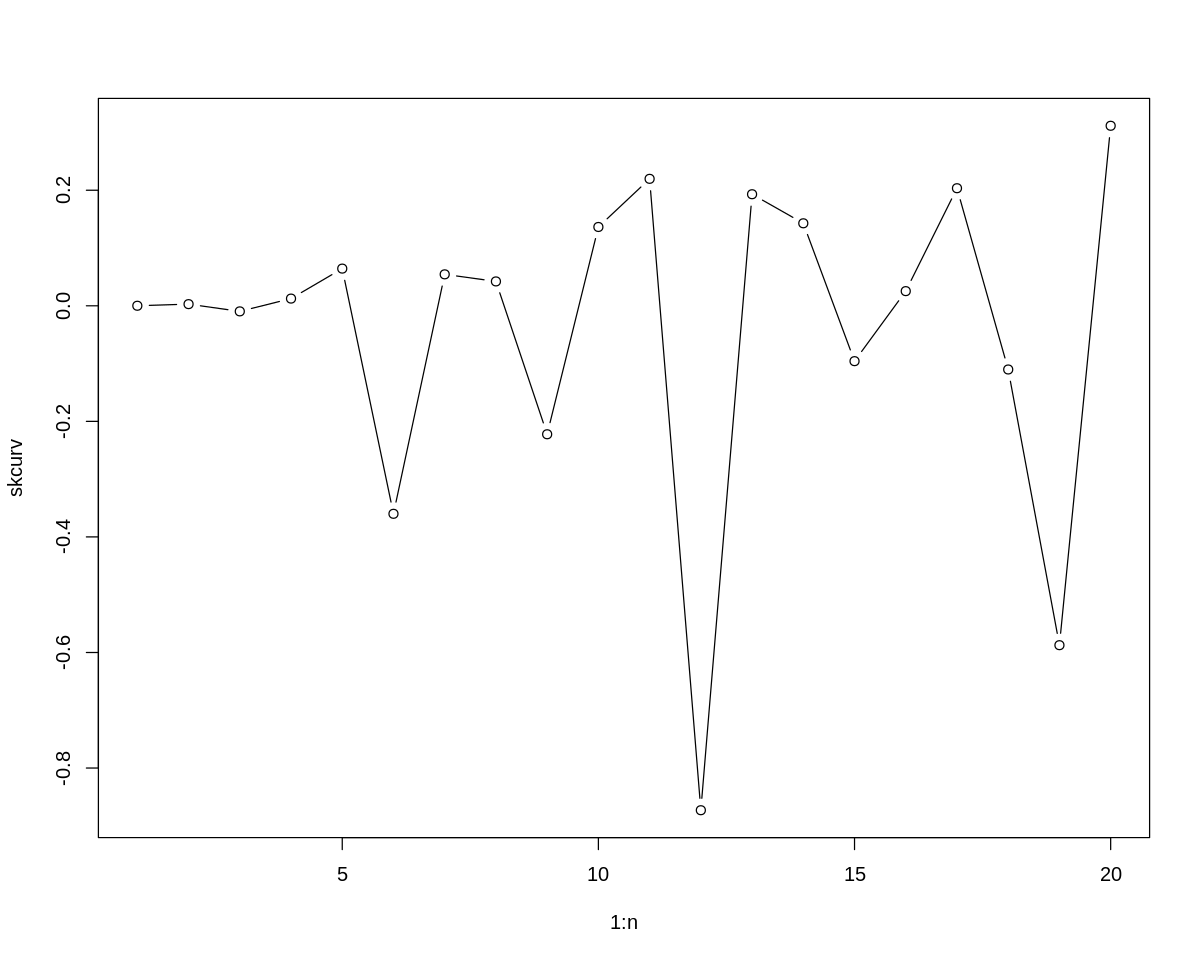

In [ ]:
plot_knee_points <- function(sk, n){
    #' It plots the graph given the singular values.

    fordiff <- function(x) x[2:length(x)] - x[1:(length(x)-1)]
    skd <- fordiff(sk)
    skdd <- fordiff(skd)
    skcurv <- skdd[1:n] / (1+(skd[1:n])^2)^1.5
    plot(1:n, skcurv, type="b")
}

plot_knee_points(lsar$sk, 20)

Let's test the first local minimum, that is 6, namely we take the first 6 latent dimensions.

In [ ]:
sim_5_dim <- top(cosines(dls[,1:6], heart_long_ls[1:6]), 10)

# List the 10 songs
songs_df[sim_5_dim, c('title','artist_name', 'tag')]

,title,artist_name,tag
,<chr>,<chr>,<chr>
66841,Moonlight And Roses (Bring Memories Of You),Jim Reeves,jim reeves
144585,If Dreams Come True,Billie Holiday,jazz
19347,Moonlight And Roses,Vic Dana,easy listening
10789,Elements Of Life,Alice DJ,trance
59697,Alone Together,Rufus Wainwright,Broadway
33452,A True True Love (1989 Digital Remaster),Bobby Darin,easy listening
144977,Impress.,The Chariot,hardcore
121633,Feel Me Heaven,Enigma,new age
132305,Alone Together,Carly Simon,oldies


In [ ]:
as.list(songs_df[c(66841, 19347, 132305), 'lyrics'])

[[1]]
[1] "you you you and and and in my of of of love love so heart dream dream light light thought true bring bring bring wonder beauti memori memori memori rose rose rose golden golden moonlight moonlight moonlight sparkl sparkl june june"

[[2]]
[1] "you you you you and and and and in my of of of of love love so heart dream dream light light thought true bring bring bring bring wonder beauti memori memori memori memori rose rose rose rose golden golden moonlight moonlight moonlight moonlight sparkl sparkl june june"

[[3]]
[1] "the the the the the the the the you you to to to to and and and a a a a me me not not in is is is is is is is are are are are are are are are are we we we we we we we we we for be be be be love love love love love love love love love love what can can can can can can there if if as as as as as as as as as as as as as as as as as as by by night our our our our our our world too long long long alon alon alon alon alon close close rain fear togeth togeth togeth togeth togeth togeth togeth togeth togeth togeth deep deep deep music sea sea blind strong abov great great great great great lyric beyond crowd vain proud weather weather unknown unknown cling"

The results seem better, as you may observe from the lyrics, increasing the information quantity. But this is a qualitative analysis, let's compute the Chi-squared test to confirm if there is a correlation between 'heart long' and 'country' genre within the latent space.

In [ ]:
# We need to fix the maximum number of returned results (R-precision), this number
# is given by the number of 'classic rock' songs within the entire dataset.
# Compute the distribution of the genre in the first k results of the search with k=1..nrow(dls)
# We have to give the possibility to retrieve all the 'country' songs that are 4043

heart_long_6_dim <- table(1:nrow(dls) %in% top(cosines(dls[,1:6], heart_long_ls[1:6]), 4043), genres=="country" )
dimnames(heart_long_6_dim) <- list('heart long'=c("No", "Yes"), 'country'=c("No", "Yes"))
heart_long_6_dim

          country
heart long     No    Yes
       No  145477   3847
       Yes   3847    196

In [ ]:
chisq.test(heart_long_6_dim, correct=FALSE)


	Pearson's Chi-squared test

data:  heart_long_6_dim
X-squared = 79.14, df = 1, p-value < 2.2e-16


Also considering the latent space, the probability that the query 'heart long' and the genre 'country' are not related is very low. We have a confirmation of this result from a lexical and a semantic point of view. Let's test if we also get a similar result for the second query 'heart insid'.

In [ ]:
heart_insid_6_dim <- table(1:nrow(dls) %in% top(cosines(dls[,1:6], heart_insid_ls[1:6]), 4043), genres=="country" )
dimnames(heart_insid_6_dim) <- list('heart insid'=c("No", "Yes"), 'country'=c("No", "Yes"))
heart_insid_6_dim

           country
heart insid     No    Yes
        No  145461   3863
        Yes   3863    180

In [ ]:
chisq.test(heart_insid_6_dim, correct=FALSE)


	Pearson's Chi-squared test

data:  heart_insid_6_dim
X-squared = 53.353, df = 1, p-value = 2.787e-13


In this case the previous result has been refused, considering the semantics, the two terms 'heart' and 'insid' are correlated.

## Songs recommendation

The next goal is to detect the most similar songs to a given input text in order to build a simple recommendation system based on song lyrics. As first thing we need to load on a dataframe the evaluation dataset that we downloaded at the beginning of the notebook, it contains for each song a list of similar songs.

In [6]:
evaluation_df <- read.csv(dl_eval$local_path)
# Removing the lyrics to avoid ugly output in the cell
evaluation_df[1:3, names(evaluation_df) != "lyrics"]

,track_id,title,artist_name,tag,target
,<chr>,<chr>,<chr>,<chr>,<chr>
1,TRAAGJV128F1464090,It's My Party,Lesley Gore,60s,"TRDRFLI128F92C94CB,TRQQEEF128F92D5BC4,TRBTMXC128F93462EA,TRTBJAL128F42264D3,TRRVDDS128F426F4B7,TRADZQV128F14A5760,TRGWVXK12903CEBA65,TREANGJ128F14989F6,TRMAIRM128F148527E,TRCPSJI12903CD9879,TRHOGMB128F1481949,TRVHVFC128F92F1387,TRMTJVR128F42869A3,TRVXAKZ128F9338E4B,TRQOZWP128F145AD6C,TRSGIEM128F426BD0A,TRBJLVI128F931DE54,TRZVGBD12903CD74A8,TRJRJKS128F4272C7D,TRAUZVU12903CC050D,TRKSWBS128F426BF3D,TRNONPQ128F424EAD1,TRLYOPY12903CEA123,TRZRJPO128F92EF9C8,TRHYPXT128F9311D29,TRFTAVP128F9311F1A,TRPTUSH128F932EB11,TRONWPP128F42A001A,TRWRMVQ128F421CC11,TRFMIED128F932D8D7,TRIMGYM128E07848C0,TRECXNL128F93227D6,TRXASKT128F92F2D0F,TRLHNLY12903CC0587,TRDGHLY12903CDF60D,TRBRPQK128E07936CD,TRFNVHG128F92D2F81,TRRXMOY12903CB89CE,TRFZWND128F92F84EF,TRZPVUW128E0788A3E,TRYSOIO128F145B04D,TRRAXDO128F9318792,TRTAQMT128EF34FDBD,TRQWKVN128F930F016,TRVRICO128F92CF02F,TRMLSWF128F4252EB7,TRCNLXE12903CC096A,TROQYZD128F92C72BD,TRWSUUY128F14A8CE5,TRBRPIA128F4289506,TRGPUFE128F92CD8C3,TRVQMKL128F4289505,TRHHDYL128F92FC562,TRDZAJJ128F9311EFB,TRRLUML128F145BE12,TRIBBAQ128EF3498C1,TRHMZSP128F145B044,TRSTHYK12903CEB8FA,TRIBLBP128F1485E1C,TRAONAP128F145672D,TRSJDGT128F427B62C,TREEWWU128F932A4F6,TRJHZGS12903CE9854,TRQABRI128F14AD376,TRIUJEC12903CBCD99,TRWNRCJ128F92F2D3C,TRQXNDU128F92E722A,TRASDYZ128F92FB0DF,TRGXQFQ128F427CC14,TRDDLBK128F933D433,TRACXGH128F931686C,TRTPXWT128F92FE179,TRJTTNG128F4269122,TRKANWW128F931EC0D,TRVEJTZ12903CA367C,TRJKCEY128F428A578,TRPEEHW128F92F2D0C,TROTYIP128EF365D9D,TRIMALA128F92D2B82,TRUPLRX128F932DE4C,TRAQPUZ128F4299119,TRPYKTG128F42264DE,TRJCUYC128EF34FDBE,TRUMETS128F92CEBF5,TRZJIGI12903CD8859,TRMQOZH128F92D41AC,TRJJRVT12903CD77BD,TRFFQVT128F146519E,TRNTKJE128F92F2E27,TRYBYMN128EF34FE02,TRHCWPI12903CC525B,TRXDHEF12903CB601B,TRIVDKJ12903CBC905,TRCFHUM128F42591BE,TRLBXQC128F1461E67,TROPASI128F148B751,TRLZJNM128F930E168,TRPZXJX12903CD4C72,TRPKZGZ128F4299118,TRTZIUX128F4240C17,TRAATJP12903CBA7D7,TRKBWVZ128F425F757,TRNBBBH128F92F2D1B,TRFDZYB12903CAB761,TRCSFWV128F933D827,TRWQHZM12903CDDB07,TRCACUG128F92F19D1,TRIPPIC12903CA3689,TRRWFSQ128E0790AC7,TRCLKCO12903CDDB09,TRLQYWK12903CDF8E5,TRKKGJC12903C9FBB5,TROKJBE12903CC9D74,TRVPAQW128F1495910,TRBIUKI128EF349898,TRQVTKP12903CF8AD4,TRHMBSZ128F92D2B67,TRAWOYN128F92F2D34,TRGRGBO128F9349207,TRSWIRD12903CFB6A0,TRIIDLR12903CC6630,TRRJENJ12903CF773F,TRYUQKT128F92F11F5"
2,TRACLRS12903CE9386,Stand By Your Man,Tammy Wynette,country,"TRZUDKE128F14639C0,TRNWWEL12903CA68E0,TRMNZCC128F429BEE1,TROZRVM12903CF0980,TRHRFVN128F429746F,TRAPYDH128F42651CD,TROUNWQ128F421F386,TRPCUHW12903CA10F7,TRCFSXM12903CC84F4,TRGXKDG12903CEB66B,TREBMHU12903CEB8B1,TRYLQRQ128F1456F60,TRPETJN12903CB60C2,TRJWHCR128F145BC73,TRPMRZN12903CAAEF7,TRABEEJ12903C9748C,TRVDQHY128F933D819,TRUNQUB12903D06F5D,TRLWORY128F92EFCE7,TRKQRGK128F4289F66,TRWZONW128F92E88D4,TRCUBIF128F1484D05,TRCVXLD128F1484D0A,TRNMQKX128F9320219,TRBYPWF128F4285786,TRRNLXA128F1484D15,TRGEVUL12903CE73D1,TRWAXNU128F1484CEB,TRAQTYT12903D134AC,TRRCXHE128F4289827,TRNFARA128F4291328,TRNRQRF128F93595A5,TRYEMLL128F42796B1,TRIYBPZ128F92E9D8A,TRUHUCW128F92FE980,TRKGQSV12903CD7DD3,TRMPPKI128F92F0A86,TRZSJPY128F9320981,TROQQTV128F92F4DA9,TRHOHLR12903CB7AFE,TRBMBCU128F4262031,TRLOEWP128F42482AC,TRCLZZY128F4289D09,TRXJRAZ128F92EC2DD,TRJIJTW128F4289A7E,TRHCVXH128F426BE7F,TRTCOLD128F92C91A7,TRGMNMX128F42705EC,TRUWYNZ128F427023B,TRQIZVH128F428075C,TRCFKCK128F92F09DF,TRAKUMK128F933AA30,TRKGMFR128F1484D0D,TRCTJJN128F1461F0A,TRSLKNE12903CD7FF3,TRWDZIO128F92EF1BB,TRSRPZM128F93225CD,TRRNGZF128F428D11E,TROAGJQ128F92EB93C,TRWWEYX128F92D6338,TRPKCEU128F423C429,TRADYYF128F1459C8E,TRCQQQB128F92D6327,TRZENWV128F92E37A1,TRYEWVB128F42739EB,TRZTWFB128F429324E,TRDKHWE128F42666C5,TRNDFGY128F148D04D,TRJEBIT128F933A400,TREOFVN128F14570CA,TRAONAP128F145672D,TRJMLVN128F92FC085,TRTNKIL128F92E361A,TRHMTFX128F92F09F1,TRNJJFT128F935973D,TRPEYMT128F4259396,TREFEUS128E078F7D5,TRWXGIH128F92ED

In [ ]:
min_similar <- min(sapply(sapply(evaluation_df$target, strsplit, split=","), length))
cat("The evaluation dataframe contains", nrow(evaluation_df), "songs with at least", min_similar, "similar ones.")

The evaluation dataframe contains 200 songs with at least 106 similar ones.

We decided to make two simple recommendation system, the first one uses the document matrix of the latent space and then we compute the most similar songs considering the cosine similarity. In the second one, we built a doc2vec model and we computed the most similar songs considering the inner product between the document embeddings.

First of all we need to create a function that compares the track ids of the returned songs with the one of the actual similar ones. 

Furthermore, we import the Metrics package that allows to compute the mean average precision at k and we implement a simple function that return the mAP@k given the vector of predictions and actual similar songs.

The average precision at k is the sum from P@1 to P@k of the precisions, divided by k. The mean of these values -each query submitted to the system- is the mean average precision.

In [7]:
install.packages('Metrics', quiet=T)
library('Metrics')

# Import pbapply to show progress while evaluating the dataframe
install.packages("pbapply", quiet=T)
library(pbapply)

opb <- pboptions(char="=", title="Computing mAP on the evaluation dataset", type="timer")

The ***compute_mAP_k*** and the ***compute_recall*** function is in common between the two methods that we will test on the evaluation dataframe, therefore we declare them here.

In [8]:
compute_mAP_k <- function(k, target, predicted) {
    #' This function return the mAP@k for the 2 given vectors.
    #'
    #' @param predicted It's the vector of predicted track ids.
    #' @param target It's the vector of similar track ids.
    #' @param k Max length of predicted sequence.

    map_res <- mapk(k, target, predicted)
    return(map_res)
}


compute_recall <- function(target, predicted) {

    scores <- rep(0, length(predicted))
    #' It returns the recall considering the target and predicted
    #' vectors.
    for (i in 1:length(predicted)){
        targ <- unique(target[[i]])
        pred <- unique(predicted[[i]])
        
        tp <- length(intersect(targ, pred))
        fp <- length(setdiff(pred, targ))
        fn <- length(setdiff(targ, pred))
        if (tp == 0) {
            recall <- 0 
        } else {
            recall <- tp / (tp + fn)
        }
        scores[i] <- recall
    }   
    
    return(mean(scores))
}

In the original challenge of the Million Songs Dataset, the models were evaluated considering mAP@500. Unfortunately, we have to use only the songs from the evaluation dataset for which we also have the lyrics, given that my analysis is based on the texts, therefore the maximum mAP that we are able to compute is at 105 for 200 songs. We tried to find a balance between the k of the mAP and the number of songs to test.

In [11]:
#@title #### Functions to test the random model

random_prediction <- function(row, k, probabilities, genres, songs_df){
    #' It computes the predicted songs randomly considering the vector of passed
    #' probabilities, that represents the distribution of the genres.

    # Compute the random genres to take the predicted song from
    pred_genres <- sample(genres, k, replace=T, prob=probabilities)
    # Take the songs from the randomly predicted genres
    preds <- list()
    for (i in 1:k){
        # Take a random song from the ones of the predicted random genre
        pred_songs <- sample_n(songs_df[songs_df['tag'] == pred_genres[i], ], 1)['track_id']
        preds <- append(preds, pred_songs)
    }
    return(paste(preds, collapse=","))
}


eval_rand_model <- function(eval_df, songs_df, k){
    #' It computes the recall@k and the mAP@k for each song that is in the 
    #' evaluation dataframe and it returns them.

    genre_data <- songs_df %>% count(tag, name="Prob", sort=TRUE)
    # Divide to get the probability for each genre
    genre_data["Prob"] <- genre_data['Prob'] / nrow(songs_df)
    genre_probs <- as.list(genre_data['Prob'])[[1]]
    genre_names <- as.list(genre_data['tag'])[[1]]

    # Predict the songs considering the genre distribution
    eval_df['predictions'] <-  pbapply(eval_df[, c("tag",'track_id')], 1, random_prediction, k=k, 
                                        probabilities=genre_probs, genres=genre_names, songs_df=songs_df)

    predictions <- sapply(eval_df$predictions, strsplit, split=",", USE.NAMES=F)
    targets <- sapply(eval_df$target, strsplit, split=",", USE.NAMES=F)
    recall <- compute_recall(targets, predictions)
    map_k <- compute_mAP_k(k, targets, predictions)
    return(c(recall, map_k))
}

We have to check, before our evaluation, what are the results obtained using a random recommender that uses the genre distribution in the dataset. We compute the distribution of the genres in the training dataset and for each song in the evaluation dataset we sample a genre, considering the probabilities, and k random songs from those genres.

In [16]:
res_random <- eval_rand_model(evaluation_df, songs_df, 105)
cat("\n- The mAP@105 obtained by the random classifier is ", res_random[2])
cat("\n- The recall@105 obtained by the random classifier is ", res_random[1])

 |==================================================| 100% elapsed=05m 15s
- The mAP@105 obtained by the random classifier is 2.556225e-05
- The recall@105 obtained by the random classifier is 0.0009119754

### Latent semantic space approach

We implemented some functions to simplify the next steps.     
The first function is used to create the vector in the latent space given a song id. It retrieves the lyrics of that song from the dataframe and it creates a vector on them.

The second one is used to actually retrieve the *n* most similar songs, considering the desired latent dimensions and computing the cosine similarity between the given vector and the documents latent matrix.

In [ ]:
#@title #### Functions to create a latent vector and compute most similar songs
#@markdown If you expand the cell you will find the implementation of the 2 functions

create_lsa_vector <- function(song_id, df, words, tdm) {
    #' It returns the lsa vector of a song, given its name.
    #'
    #' @param song_name The string that represent the unique song id.
    #' @param df The dataframe from which the function retrieves the lyrics.
    #' @param words The list of words used to build the LSA space.
    #' @param tdm The document-term matrix to use for the operation.

    # If a dataframe is passed the function takes the lyrics from that
    if (inherits(df, "data.frame")){
        lyrics <- df[df$track_id == song_id, "lyrics"]
    }
    else{
        lyrics <- df
    }
    lyrics_vec <- query(lyrics, words)
    lyrics_le <- lw_logtf(lyrics_vec) * (1-entropy(tdm))
    lyrics_ls <- t(lyrics_le) %*% lsar$tk
    return(lyrics_ls)
}


compute_most_similar_songs <- function(dls, l_dim, df, song_vec, n) {
    #' It returns the dataframe with the most similar songs to the one given as
    #' input.
    #'
    #' @param dls The document-term matrix of the latent space.
    #' @param l_dim The latent dimensions to use for computing the cosine similarity. Passed as a list.
    #' @param df The dataframe from which the function will retrieve the information about the similar songs.
    #' @param song_vec The latent vector that represents the song for which we want similar ones.
    #' @param n The number of similar songs the function has to retrieve.

    sim_song_idx <- top(cosines(dls[, l_dim], song_vec[l_dim]), n)
    return(df[sim_song_idx, names(df) != 'lyrics'])
}

In [ ]:
#@title #### Functions to compute the mAP@k and the recall for the evaluation dataframe using LSI
#@markdown If you expand the cell you will find the implementation of the functions.
predict_row <- function(eval_data, songs_df, l_dim, k) {
    #' It creates the vector for the song, compute the most similar ones and returns them as string.
    #' 
    #' @param eval_data It's the list of data taken from one row of the evaluation dataframe.
    #' @param songs_df The dataframe of songs that the function gives as input to
    #'        'create_lsa_vector'.
    #' @param l_dim The latent dimensions to consider for the cosine similarity.
    track_id <- eval_data['track_id']

    song_vec <- create_lsa_vector(track_id, eval_data['lyrics'], words, tdm)
    predicted <- compute_most_similar_songs(dls, l_dim, songs_df, song_vec, k)
    return(paste(predicted$track_id, collapse=","))
}


evaluate_dataset <- function(eval_df, songs_df, k, l_dim) {
    #' It makes the prediction for each element of the evaluation dataframe and it
    #' saves the results in the 'predictions' column, then it computes the mAP.

    eval_df['predictions'] <- pbapply(eval_df, 1, predict_row, songs_df=songs_df, l_dim=l_dim, k=k)
    # Transform each string in a list to compute the mAP
    predictions <- sapply(eval_df$predictions, strsplit, split=",", USE.NAMES=F)
    targets <- sapply(eval_df$target, strsplit, split=",", USE.NAMES=F)

    recall <- compute_recall(targets, predictions)
    map_k <- compute_mAP_k(k, targets, predictions)
    return(c(recall, map_k))
}

Let's start computing the mAP@105 considering the third and fourth latent dimensions for the cosine similarity function, given that we based our analysis on those.

In [ ]:
k_map = 105

res_4 <- evaluate_dataset(evaluation_df, songs_df, k_map, 3:4)
cat("The mAP@105 for the songs is: ", res_4[2])
cat("The recall@105 for the songs is: ", res_4[1])

  |==================================================| 100% elapsed=10m 56s
The mAP@105 for the songs is:  9.250686e-05
The recall@105 for the songs is: 0.000959988

Now we leverage the knee points, that you can see in the graph below, in order to test the best number of dimensions to keep for improving the mAP.

The first interval is from the first dimension to the sixth.

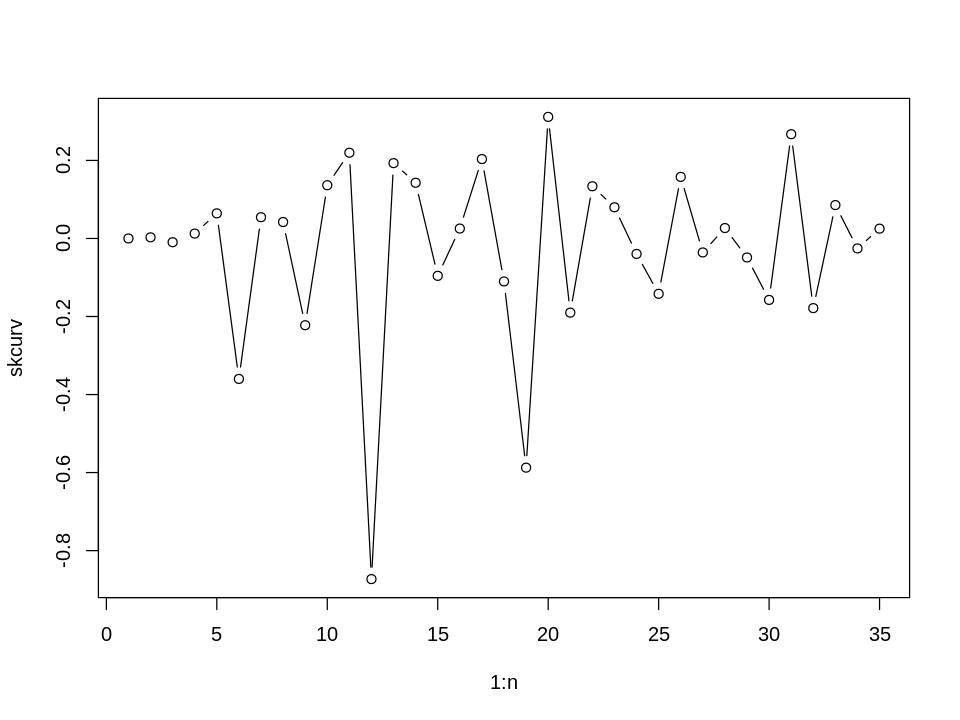

In [ ]:
options(repr.plot.width=8, repr.plot.height=6)
plot_knee_points(lsar$sk, 35)

In [ ]:
res_6 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:6)
cat("The mAP@105 for the songs is: ", res_6[2])
cat("The recall@105 for the songs is: ", res_6[1])

  |==================================================| 100% elapsed=11m 08s
The mAP@105 for the songs is: 0.0001259683
The recall@105 for the songs is: 0.001980783

The second one is considering up to the ninth dimension.

In [ ]:
res_9 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:9)
cat("The mAP@105 for the songs is: ", res_9[2])
cat("The recall@105 for the songs is: ", res_9[1])

  |==================================================| 100% elapsed=11m 06s
The mAP@105 for the songs is: 0.0002021248
The recall@105 for the songs is: 0.002066338

The score is growing therefore we should continue considering more dimensions, now we consider up to the twelfth.

In [ ]:
res_12 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:12)
cat("The mAP@105 for the songs is: ", res_12[2])
cat("The recall@105 for the songs is: ", res_12[1])

  |==================================================| 100% elapsed=11m 09s
The mAP@105 for the songs is: 0.0002466977
The recall@105 for the songs is: 0.003018142

Consider the first 15 dimensions.

In [ ]:
res_15 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:15)
cat("The mAP@105 for the songs is: ", res_15[2])
cat("The recall@105 for the songs is: ", res_15[1])

  |==================================================| 100% elapsed=11m 07s
The mAP@105 for the songs is: 0.0002735607
The recall@105 for the songs is: 0.002360622

The recall got worse but it may be a coincidence, therefore we continue with 19 dimensions.

In [ ]:
res_19 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:19)
cat("The mAP@105 for the songs is: ", res_19[2])
cat("The recall@105 for the songs is: ", res_19[1])

  |==================================================| 100% elapsed=11m 21s
The mAP@105 for the songs is: 0.0002538962
The recall@105 for the songs is: 0.001936289

The scores still got worse, if the next point is even worse we may stop the search. Try with 21 dimensions.

In [ ]:
res_21 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:21)
cat("The mAP@105 for the songs is: ", res_21[2])
cat("The recall@105 for the songs is: ", res_21[1])

  |==================================================| 100% elapsed=11m 16s
The mAP@105 for the songs is: 0.0002830556
The recall@105 for the songs is: 0.002501981

The metrics improved again, therefore we continue to increase the number of taken dimensions, now it is 25. 

In [ ]:
res_25 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:25)
cat("The mAP@105 for the songs is: ", res_25[2])
cat("The recall@105 for the songs is: ", res_25[1])

  |==================================================| 100% elapsed=11m 18s
The mAP@105 for the songs is: 0.0003227802
The recall@105 for the songs is: 0.002833314

In [ ]:
res_30 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:30)
cat("The mAP@105 for the songs is: ", res_30[2])
cat("The recall@105 for the songs is: ", res_30[1])

  |==================================================| 100% elapsed=11m 21s
The mAP@105 for the songs is: 0.000298327
The recall@105 for the songs is: 0.002064596

In [ ]:
res_32 <- evaluate_dataset(evaluation_df, songs_df, k_map, 1:32)
cat("The mAP@105 for the songs is: ", res_32[2])
cat("The recall@105 for the songs is: ", res_32[1])

  |==================================================| 100% elapsed=11m 43s
The mAP@105 for the songs is: 0.0002913192
The recall@105 for the songs is: 0.002046135

The best result is obtained considering up to the twenty-fifth eigenvalue and then we stopped the search because there are no more improvements, we probably reached a plateau, as you can notice in the following graph about the mAP@105.

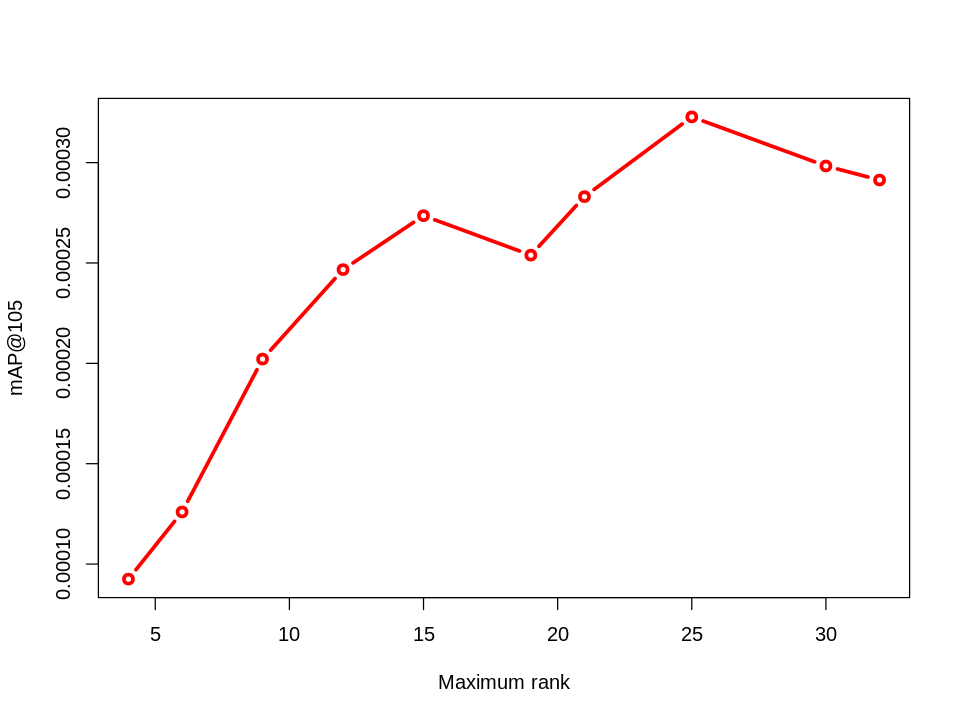

In [ ]:
map_index <- c(4, 6, 9, 12, 15, 19, 21, 25, 30, 32)
map_results <- c(res_4[2], res_6[2], res_9[2], res_12[2], res_15[2], res_19[2], res_21[2], res_25[2], res_30[2], res_32[2])

options(repr.plot.width=8, repr.plot.height=6)
plot(map_index, map_results, type="b", col="red", lwd=3, xlab="Maximum rank", ylab="mAP@105")

We also want to look at the recall@105 chart, to check with how many dimensions we obtained the better result. 

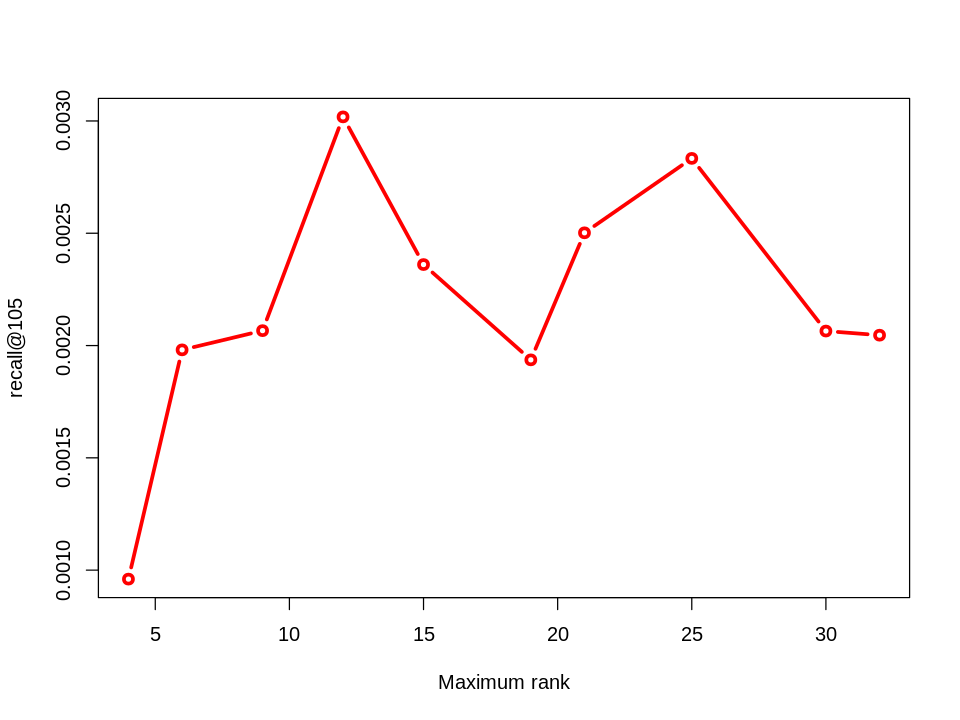

In [ ]:
rec_index <- c(4, 6, 9, 12, 15, 19, 21, 25, 30, 32)
rec_results <- c(res_4[1], res_6[1], res_9[1], res_12[1], res_15[1], res_19[1], res_21[1], res_25[1], res_30[1], res_32[1])

options(repr.plot.width=8, repr.plot.height=6)
plot(rec_index, rec_results, type="b", col="red", lwd=3, xlab="Maximum rank", ylab="recall@105")

The obtained mAP scores are very low, this means that the suggestions are not accurate. There could be different reasons:
- it's difficult to suggest a song based on the lyrics alone, different genres can have similar texts but other completely different features (tempo, melody, ...).
- The representative words for a genre / songs are few with respect to the entire dictionary of considered words.
- The songs are a lot and not very divided in clusters, as said before, therefore there are many possible suggestions and similar to each other.

Considering also the recall we can conclude that the best number of eigenvalues to take is 25, because we reached the best ***mAP@105*** of *0.000322* and the second best score for the ***recall***, *0.00283*. Furthermore our simple system performs better than the random classifier, therefore it learns something even if the scores are very low.

### Doc2Vec method

In order to compare the previous system with others, we will try the ***Doc2Vec*** algorithm, that creates an embedding for each document and then we compute the most similar to a given one.

We used the method called Paragraph Vector with a Distributed Bag Of Words (PVDBOF), it is based on the Word2vec skip-gram model, with one exception,instead of using the target word as the input, it takes the document ID as the input and tries to predict randomly sampled words from the document.

In [ ]:
install.packages("doc2vec", quiet=T)
library("doc2vec")

In the given package, there is a limit of maximum 1000 words for each document (song lyrics) and therefore we have to remove all the songs with more than 1000 words. Furthermore, we keep only the 'track_id' and 'lyrics' columns and we rename them to 'doc_id' and 'text' as requested by the library.

In [ ]:
# Remove songs with more than 1000 words and keep the right columns
corpus_doc2vec <- songs_df[(sapply(sapply(songs_df$lyrics, strsplit, split=" "), length) <= 1000), c('track_id', 'lyrics')]
names(corpus_doc2vec) <- c('doc_id', 'text')

In [ ]:
cat("The removed songs are", nrow(songs_df) - nrow(corpus_doc2vec))

The removed songs are 143

The first time that we executed it, we need to compute the model, afterwards we pre-save it and you can simply execute the following cell to download it from Drive. It is reasonable to use 100 dimensions for the document embeddings.

In [ ]:
#@title #### Load the pre-saved doc2vec model from Drive
# Download from Drive
url_doc2vec <- "https://drive.google.com/file/d/16d35sHK0abLBud5tMmZRHfRRo3GA_vsa/view?usp=share_link"

drive_deauth()
dl_doc2vec <- drive_download(as_id(url_doc2vec), overwrite=TRUE)

# Read the model
doc2vec_model <- read.paragraph2vec(dl_doc2vec$local_path)
str(doc2vec_model)

File downloaded:

• doc2vec_model.bin <id: 16d35sHK0abLBud5tMmZRHfRRo3GA_vsa>

Saved locally as:

• doc2vec_model.bin



List of 3
 $ model     :<externalptr> 
 $ model_path: chr "doc2vec_model.bin"
 $ dim       : num 100
 - attr(*, "class")= chr "paragraph2vec"


In [ ]:
#@title #### Compute the doc2vec model on the corpus (~60 minutes)
cat("Computing the embeddings ...")
# Compute the doc2vec from the corpus 
doc2vec_model <- paragraph2vec(corpus_doc2vec, dim=100, threads=2)

cat("\nSaving the model into a file ...")
write.paragraph2vec(doc2vec_model, "doc2vec_model.bin")

Computing the embeddings ...
Saving the model into a file ...

In [ ]:
# Retrieve document embeddings as matrix
emb_docs <- as.matrix(doc2vec_model, type="docs")

We can wrote a couple of functions in order to compute the mAP@105 considering the doc2vec model.

In [ ]:
#@title #### Functions to compute the mAP@k for the evaluation dataframe considering doc2vec

compute_similars_doc2vec <- function(doc2vec_model, emb_docs, lyrics_list, k=105) {
    #' It returns the list of most similar song ids.
    #'
    #' @param doc2vec_model The doc2vec model trained on songs_df.
    #' @param emb_docs The matrix of the document embeddings.
    #' @param lyrics_list The lyrics of a song as a list of words.
    #' @param k The number used to compute the mAP.

    embedding <- predict(doc2vec_model, lyrics_list, type="embedding")
    # Compute the most similar documents considering the doc2vec embedding
    predictions <- paragraph2vec_similarity(embedding, emb_docs, top_n=k)['term2']
    #predict(doc2vec_model, newdata=lyrics_list, type="nearest", which="sent2doc", top_n=k)
    return(unname(as.list(predictions))[[1]])
}


predict_row_doc2vec <- function(eval_data, doc2vec_model, emb_docs, k) {
    #' It creates the vector for the song, compute the most similar ones and returns them as string.
    #' 
    #' @param eval_data It's one row of the evaluation dataframe.
    #' @param doc2vec_model It's the doc2vec model created on the songs dataset.
    #' @param emb_docs The matrix of the document embeddings.
    #' @param k The number of predictions to compute.

    lyrics_list <- list(pred=strsplit(eval_data['lyrics'], split=" ")[[1]])
    predicted <- compute_similars_doc2vec(doc2vec_model, emb_docs, lyrics_list, k)
    return(paste(predicted, collapse=","))
}


evaluate_dataset_doc2vec <- function(eval_df, doc2vec_model, emb_docs, k) {
    #' It computes the mAP@k on the passed evaluation dataframe
    #'
    #' @param eval_df The evaluation dataframe to consider for computing the mAP.
    #' @param doc2vec_model The doc2vec model to use for the operations.
    #' @param emb_docs The matrix of the document embeddings.
    #' @param k The number to consider to compute the mAP

    eval_df['predictions'] <- pbapply(eval_df, 1, predict_row_doc2vec, doc2vec_model=doc2vec_model, emb_docs=emb_docs, k=k)
    # Transform each string in a list to compute the mAP
    predictions <- sapply(eval_df$predictions, strsplit, split=",", USE.NAMES=F)
    targets <- sapply(eval_df$target, strsplit, split=",", USE.NAMES=F)

    recall <- compute_recall(targets, predictions)
    map <- compute_mAP_k(k, targets, predictions)

    return(c(recall, map))
}

In order to avoid errors, we also have to remove the songs with more than 1000 words from the evaluation dataframe.

In [ ]:
# Otherwise crash of the RAM
evaluation_df <- evaluation_df[(sapply(sapply(evaluation_df$lyrics, strsplit, split=" "), length) <= 1000), ]
cat("The evaluation dataframe has now", nrow(evaluation_df), "songs.")

The evaluation dataframe has now 200 songs.

In [ ]:
res_doc2vec <- evaluate_dataset_doc2vec(evaluation_df, doc2vec_model, emb_docs, 105)

cat("The mAP@105 considering the doc2vec model is", res_doc2vec[2])
cat("\nThe recall@105 considering the doc2vec model is", res_doc2vec[1])

  |==================================================| 100% elapsed=21s  
The mAP@105 considering the doc2vec model is 0.0001667032
The recall@105 considering the doc2vec model is 0.001621216

As you can notice, the resulting score is worse than the best obtained using LSI, therefore we can conclude that in this case a count based model (LSA) is better than a prediction based model (Doc2Vec). 

Even though both approaches, considering only the song lyrics, don't work very well for a songs recommendation system. 